# HSE 2021: Mathematical Methods for Data Analysis

## Homework 4

### Attention!
* For tasks where <ins>text answer</ins> is required **Russian language** is **allowed**.
* If a task asks you to describe something (make coclusions) then **text answer** is **mandatory** and **is** part of the task
* **Do not** upload the dataset to the grading system (we already have it)
* We **only** accept **ipynb** notebooks. If you use Google Colab then you'll have to download the notebook before passing the homework
* **Do not** use python loops instead of NumPy vector operations over NumPy vectors - it significantly decreases performance (see why https://blog.paperspace.com/numpy-optimization-vectorization-and-broadcasting/), will be punished with -0.25 for **every** task. 


### Contents

#### Decision Trees - 7 points
* [Task 1](#task1) (0.5 points)
* [Task 2](#task2) (0.5 points)
* [Task 3](#task3) (2 points)
* [Task 4](#task4) (0.5 points)
* [Task 5](#task5) (0.5 points)
* [Task 6](#task6) (2 points)
* [Task 7](#task7) (0.5 points)
* [Task 8](#task8) (0.5 points)

#### Ensembles - 3 points
* [Task 1](#task2_1) (1 point)
* [Task 2](#task2_2) (0.7 points)
* [Task 3](#task2_3) (0.5 points)
* [Task 4](#task2_4) (0.7 points)
* [Task 5](#task2_5) (0.1 points)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams['figure.figsize'] = (11, 5)
%matplotlib inline

# Part 1. Decision Tree Regressor

In this task you will be implementing decision tree for the regression by hands. 

### Task 1 <a id="task1"></a> (0.5 points)

Implement the function `H()` which calculates impurity criterion. We will be training regression tree, therefore, impurity criterion will be variance.

* You cannot use loops
* If `y` is empty, the function should return 0

In [2]:
def H(y):
    """
    Calculate impurity criterion
    
    Parameters
    ----------
    y : np.array
        array of objects target values in the node

    Returns
    -------
    H(R) : float
        Impurity in the node (measuread by variance)
    """
    if ((len(y)) == 0):
        H = 0.
    else:
        H = np.mean((y - np.mean(y)) ** 2)
    return H

In [3]:
# Test the function
assert np.allclose(H(np.array([4,2,2,2])), 0.75)
assert np.allclose(H(np.array([])), 0.0)

### Task 2 <a id="task2"></a>  (0.5 points)

To find the best split in the node we need to calculate the cost function. Denote: 
- `R` all the object in the node
- `j` index of the feature selected for the split
- `t` threshold
- `R_l` and `R_r` objects in the left and right child nodes correspondingly

We get the following cost function:

$$
Q(R, j, t) =\frac{|R_\ell|}{|R|}H(R_\ell) + \frac{|R_r|}{|R|}H(R_r) \to \min_{j, t},
$$

Implement the function `Q`, which should calculate value of the cost function for a given feature and threshold.

In [4]:
def Q(X, y, j, t):
    """
    Calculate cost function
    Parameters
    ----------
    X : ndarray
        array of objects in the node 
    y : ndarray
        array of target values in the node 
    j : int
        feature index (column in X)
    t : float
        threshold

    Returns
    -------
    Q : float
        Value of the cost function
    """   
    left_part = X[:, j] < t
    y_left = y[left_part]
    right_part = X[:, j] >= t
    y_right = y[right_part]
    Q = (y_left.shape[0]/y.shape[0]) * H(y_left) + \
                    (y_right.shape[0]/y.shape[0]) * H(y_right)
    return Q

### Task 3 <a id="task3"></a>  (2 points)

Now, let's implement `MyDecisionTreeRegressor` class. More specifically, you need to implement the following methods:

- `best_split`
- `grow_tree`
- `get_prediction`

Read docstrings for more details. Do not forget to use function `Q` implemented above, when finding the `best_split`

In [5]:
class Node(object):
    """
    Class for a decision tree node.
    
    Parameters
    ----------
    right : Node() or None
        Right child
    right : Node() or None
        Left child
    threshold: float
        
    column: int
        
    depth: int
        
    prediction: float
        prediction of the target value in the node (average values calculated on a train dataset)
    is_terminal:bool
        indicates whether it is a terminal node (leaf) or not
    """    
    def __init__(self):        
        self.right = None
        self.left = None
        self.threshold = None
        self.column = None
        self.depth = None
        self.is_terminal = False
        self.prediction = None
        
    def __repr__(self):
        if self.is_terminal:
            node_desc = 'Pred: {:.2f}'.format(self.prediction)
        else:
            node_desc = 'Col {}, t {:.2f}, Pred: {:.2f}'.format(self.column, self.threshold, self.prediction)
        return node_desc

In [6]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class MyDecisionTreeRegressor(RegressorMixin, BaseEstimator):
    """
    Class for a Decision Tree Regressor.

    Parameters
    ----------
    max_depth : int
        Max depth of a decision tree.
    min_samples_split : int
        Minimal number of samples (objects) in a node to make a split.
    """ 
    def __init__(self, max_depth=3, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
    
    def _more_tags(self):
        return {
            'requires_y': False
        }
            
    def best_split(self, X, y):
        """
        Find the best split in terms of Q of data in a given decision tree node. 
        Try all features and thresholds. 
        
        Parameters
        ----------
        X : ndarray, shape (n_objects, n_features)
            Objects in the parent node
        y : ndarray, shape (n_objects, )
            1D array with the object labels. 
            
        Returns
        -------
        best_split_column : int
            Index of the best split column
        best_threshold : float
            The best split condition.
        X_left : ndarray, shape (n_objects_l, n_features)
            Objects in the left child
        y_left : ndarray, shape (n_objects_l, )
            Objects labels in the left child. 
        X_right : ndarray, shape (n_objects_r, n_features)
            Objects in the right child
        y_right : ndarray, shape (n_objects_r, )
            Objects labels in the right child. 
        """
        
        # To store best split parameters
        best_split_column = None
        best_threshold = None
        # without splitting
        best_cost = H(y)
        
        for i in range(X.shape[1]):
            for t in np.unique(X[:, i]):
                
                left_part = X[:, i] < t
                y_left = y[left_part]
                right_part = X[:, i] >= t
                y_right = y[right_part]
                
                if (y_left.shape[0] == 0) or (y_right.shape[0] == 0):
                    continue
                
                new_Q = Q(X, y, i, t)
                
                if(new_Q <= best_cost):
                    best_cost = new_Q
                    best_split_column = i
                    best_threshold = t
        
        left_part = X[:, best_split_column] < best_threshold
        X_left = X[left_part, :]
        y_left = y[left_part]
                    
        right_part = X[:, best_split_column] >= best_threshold
        X_right = X[right_part, :]
        y_right = y[right_part]
        
        '''
        print('yleft = ',y_left)
        print('t = ',best_threshold)
        print('i = ',best_split_column)
        print('yright = ',y_right)
        '''
        
        return best_split_column, best_threshold, X_left, y_left, X_right, y_right
    
    def is_terminal(self, node, y):
        """
        Check terminality conditions based on `max_depth` and `min_samples_split` parameters for a given node. 
        
        Parameters
        ----------
        node : Node, 
            
        y : ndarray, shape (n_objects, )
            Object labels. 
            
        Returns
        -------
        Is_termial : bool
            If True, node is terminal
        """
        if node.depth >= self.max_depth:    
            return True
        if len(y) < self.min_samples_split:   
            return True
        return False
        
    def grow_tree(self, node, X, y):
        """
        Reccurently grow the tree from the `node` using a `X` and `y` as a dataset:
         - check terminality conditions
         - find best split if node is not terminal
         - add child nodes to the node
         - call the function recursively for the added child nodes
        
        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        X : ndarray, shape (n_objects, n_features)
            Objects 
        y : ndarray, shape (n_objects)
            Labels
        """
        
        if self.is_terminal(node, y):
            node.is_terminal = True
            node.prediction = np.mean(y)
            return
        if node.is_terminal == True:
            return
        else:
            node.column, node.threshold, X_left, y_left, X_right, y_right = self.best_split(X, y)
            node.prediction = np.mean(y)
            node.left, node.right = Node(), Node()
            node.left.depth = node.depth + 1
            node.right.depth = node.depth + 1
            self.grow_tree(node.right, X_right, y_right)
            self.grow_tree(node.left, X_left, y_left)
        return self

    def fit(self, X, y):
        """
        Fit the Decision Tree Regressor.
            
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        y : ndarray, shape (n_samples,) or (n_samples, n_outputs)
            The target values.
        Returns
        -------
        self : object
            Returns self.
        """
        # Check the input
        if y is None:
            raise ValueError('Y should not be None')
        X, y = check_X_y(X, y, accept_sparse=False)
        self.is_fitted_ = True
        self.n_features_in_ = X.shape[1]
        
        # Initialize the tree (root node, depth = 0)
        self.tree_ = Node()                             
        self.tree_.depth = 0                            
        self.tree_.prediction = np.mean(y)
        
        # Grow the tree
        self.grow_tree(self.tree_, X, y)
        return self        
    
    def get_prediction(self, node, x):
        """
        Get prediction for an object `x`
            - Return prediction of the `node` if it is terminal
            - Otherwise, recursively call the function to get predictions of the proper child
        
        Parameters
        ----------
        node : Node() object
            Current node of the decision tree.
        x : ndarray, shape (n_features,)
            Array of feature values of one object.
        Returns
        -------
        y_pred : float
            Prediction for an object x
        """
        y_pred = 0.
        if node.is_terminal == True:
            y_pred = node.prediction
        else:
            if x[node.column] < node.threshold:
                y_pred = self.get_prediction(node.left, x)
            else:
                y_pred = self.get_prediction(node.right, x)
        return y_pred
    
    def predict(self, X):
        """ 
        Get prediction for each object in X
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The input samples.
        Returns
        -------
        y : ndarray, shape (n_samples,)
            Returns predictions.
        """
        # Check input and that `fit` had been called
        X = check_array(X, accept_sparse=False)
        check_is_fitted(self, 'is_fitted_')
        
        # Get predictions
        y_predicted = []
        for x in X:
            y_curr = self.get_prediction(self.tree_, x)
            y_predicted.append(y_curr)
        return np.array(y_predicted)

In [7]:
# check yourself
from sklearn.utils.estimator_checks import check_estimator

check_estimator(MyDecisionTreeRegressor())

### Task 4 <a id="task4"></a>  (0.5 points)

Load boston dataset and split it on the train ($70\%$) and test ($30\%$). Fit Decision Tree of depth 1 and make the following plot:

- Scatter plot of the traning points (selected for split feature on the x-axis, target variable on the y-axis)
- Fitted model 

P.S. Depth of the tree is equal to the longest path from the root note to the leaf. Thus, tree with depth 1 will have exactly 1 split. 

P.P.S. Both fitted model and the training points should be on the same plot

In [8]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

In [9]:
data, target = load_boston(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3)
Desicion_Tree = MyDecisionTreeRegressor(max_depth=1)
Desicion_Tree.fit(X_train, y_train)
X_i_train = X_train[:,Desicion_Tree.tree_.column]
X_i_test = X_test[:,Desicion_Tree.tree_.column]
ans = Desicion_Tree.predict(X_test)

In [10]:
print('RMSE = ', round(np.sqrt(mean_squared_error(y_test, ans)),3))

RMSE =  7.927


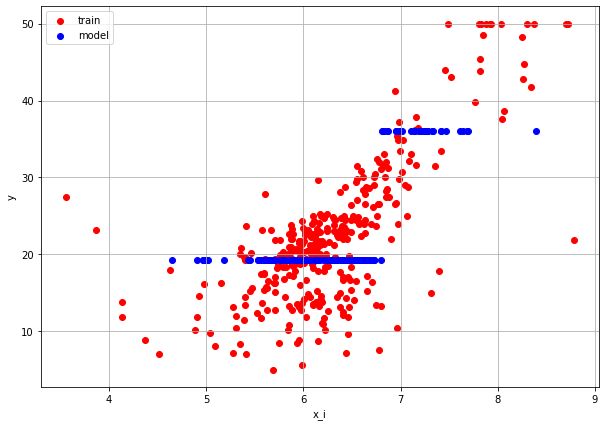

In [11]:
plt.figure(figsize=(10, 7))

plt.scatter(X_i_train,
            y_train,
            color='r',
            label='train')

plt.scatter(X_i_test,
            ans,
            color='b',
            label='model')

plt.xlabel('x_i')
plt.ylabel('y')

plt.legend(loc='best')
plt.grid(b=5)

plt.show()

### Task 5 <a id="task5"></a>  (0.5 points)

Keep working with boston dataset. 
- Use `GridSearchCV` to find the best hyperparameters (`max_depth` and `min_samples_split`) on 5-Fold cross-validation
- Train the model with the best set of hyperparameters on the whole train dataset. 
- Report `RMSE` on test dataset and hyperparameters of the best estimator. 

In [12]:
param_grid = {'max_depth': range(10), 'min_samples_split': range(2,10)}
gs = GridSearchCV(MyDecisionTreeRegressor(), param_grid=param_grid, cv=5, n_jobs=-1)
gs.fit(X_train, y_train)
gs.best_params_

{'max_depth': 5, 'min_samples_split': 6}

In [13]:
Desicion_Tree = MyDecisionTreeRegressor(max_depth = gs.best_params_['max_depth'], min_samples_split = gs.best_params_['min_samples_split'])
Desicion_Tree.fit(X_train, y_train)

MyDecisionTreeRegressor(max_depth=5, min_samples_split=6)

In [14]:
y_predicted = Desicion_Tree.predict(X_test)
print('RMSE = ', round(np.sqrt(mean_squared_error(y_test, y_predicted)),3))

RMSE =  5.473


### Task 6 <a id="task6"></a>  (2 points)

Recall definition of bias and variance:
$$
\text{Bias}^2 = \mathbb{E}_{p(x, y)} \left[  (f(x) - \mathbb{E}_{\mathbb{X}}a_{\mathbb{X}}(x))^2 \right] \\
\text{Variance} = \mathbb{E}_{p(x, y)} \left[  \mathbb{V}_{\mathbb{X}}( a_{\mathbb{X}}(x))  \right]
$$

We wil now use use the following algorithm to estimate bias^2 and variance:

1. Use bootsrap to create `n_iter` samples from the original dataset: $X_1, \dots, X_{n\_iter}$. Each $X_i$ has $N$ observations (randomly selected from the original dataset with replacement)
2. For each bootstrapped sample define out-of-bag (OOB) sample $Z_1, \dots, Z_{n\_iter}$, which contains all the observations, which did not appear in the corresponding boostraped sample
3. Fit the model on observations from $X_i$s and compute predictions on points from $Z_i$s
4. For a given *object* $x_n$:
     - bias^2: squared difference between true value $y_n$ and average prediction (average over the algorithms, for which $x_n$ was in OOB)
     - variance: variance of the predictions (predictions of the algorithms, for which $x_n$ was in OOB)
5. Average bias^2 and variance over all the points


**Consider a toy example.** You are given a dataset with 5 observations: $((x_1 ,y_1), (x_2, y_2), (x_3, y_3), (x_4, y_4), (x_5, y_5))$, where $x_i$ is a vector of features, $y_i$ is a target variable . And choose `n_iter` to be 3. 
* Example of bootstrapped samples:
$$X_1 = (x_2, x_5, x_2, x_3, x_2, x_5)$$
$$X_2 = (x_5, x_2, x_4, x_4, x_1, x_5)$$
$$X_3 = (x_1, x_3, x_1, x_4, x_3, x_1)$$

* Corresponding OOB samples:
$$Z_1 = (x_1, x_4)$$
$$Z_2 = (x_3)$$
$$Z_3 = (x_2, x_5)$$

* Fit models using $X_1$, $X_2$ and $X_3$ as training data. Use 1st model to make predictions for points from $Z_1$, second - for $Z_2$, etc. and use these predictions to estimate bias and variance. 

    
**Implement `get_bias_variance` function, using the algorithm above**

*Note:*  You can only use 1 loop (for bootsrap iterations `n_iter`). All other operations should be vectorized. 

P.S. These numpy functions might be usefull here `np.nanmean`, `np.nanstd` (but you are not obliged to use them). 

In [15]:
import warnings

In [16]:
def get_bias_variance(estimator, x, y, n_iter):
    """ 
    Calculate bias^2 and variance of the `estimator`. Using a given dataset and bootstrap with `n_iter` samples. 

    Parameters
    ----------
    x : ndarray, shape (n_samples, n_features)
        The input samples.
    y : ndarray, shape (n_samples, n_features)
        The input samples.
    n_iter: int
        Number of samples in 
    Returns
    -------
    bias2 : float, 
        Estiamted squared bias
    variance : float, 
        Estiamted variance
    """
    Y_pred = np.empty(y.shape)
    Y_pred[:] = np.nan
    for i in range(n_iter):
        l = np.random.choice(x.shape[0], size=x.shape[0])
        oob = list(set(range(x.shape[0])) - set(np.unique(l)))
        if len(oob) == 0:
            continue
        estimator.fit(x[l],y[l])
        y_pred = np.empty(y.shape)
        y_pred[:] = np.nan
        y_pred[oob] = estimator.predict(x[oob])
        Y_pred = np.vstack([Y_pred,y_pred])
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        bias2 = np.nanmean((np.nanmean(Y_pred,axis=0) - y)**2)
        variance = np.nanmean(np.nanvar(Y_pred,axis=0))
    return bias2, variance

In [17]:
# Test
estimator = MyDecisionTreeRegressor(max_depth=8, min_samples_split=15)

get_bias_variance(estimator, X_train, y_train, 10)

(13.082364760808332, 5.836245804390768)

### Task 7 <a id="task7"></a>  (0.5 points = 0.25 for code + 0.25 for comments)

Compute bias and variance for the trees of different depths. Plot how bias and variance change as depth increases. 

Comment on what you observe, how does your result correspond to what we have discussed in class?

In [18]:
bias = np.zeros(10)
var = np.zeros(10)
for i in range(10):
    estimator = MyDecisionTreeRegressor(max_depth=i, min_samples_split=7)
    b, v = get_bias_variance(estimator, X_train, y_train, 10)
    bias[i], var[i] = round(b,2), round(v,2)
    print('depth=',i, 'bias=', bias[i], 'variance=', var[i])

depth= 0 bias= 82.32 variance= 0.13
depth= 1 bias= 37.94 variance= 10.31
depth= 2 bias= 22.82 variance= 3.84
depth= 3 bias= 17.03 variance= 3.94
depth= 4 bias= 15.26 variance= 5.89
depth= 5 bias= 13.24 variance= 5.03
depth= 6 bias= 15.87 variance= 5.81
depth= 7 bias= 15.71 variance= 5.91
depth= 8 bias= 14.71 variance= 6.94
depth= 9 bias= 15.79 variance= 7.17


<function matplotlib.pyplot.show(close=None, block=None)>

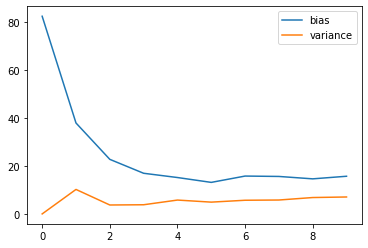

In [19]:
plt.plot(bias, label='bias')
plt.plot(var, label='variance')
plt.legend(loc='best')
plt.show

Bias-variance tradeoff takes place there, but plot is different.
Our model doesn't overfit, so variance don't increase and bias^2 don't decrease with depth increasing.

### Task 8 <a id="task8"></a>  (0.5 points = 0.25 for code + 0.25 for comments)

Let's try to reduce variance with bagging. Use `sklearn.ensemble.BaggingRegressor` to get an ensemble and compute its bias and variance. 

Answer the following questions:
 - How bagging should affect bias and variance in theory?
 - How bias and variance change (if they change) compared to an individual tree in you experiments? 
 - Do your results align with the theory? Why?

In [20]:
from sklearn.ensemble import BaggingRegressor

estimator = BaggingRegressor(base_estimator=MyDecisionTreeRegressor(max_depth=3, min_samples_split=7), n_jobs=-1, n_estimators=100)
print(get_bias_variance(estimator, X_train, y_train, 10))

(14.506994124231152, 1.9279809002714696)


Bagging improve through variance reduction only (not bias).
In comparison to the single tree variance reduces, bias changes quite a bit. This results align with the theory. Bagging makes our model more stable.

# Part 2. More Ensembles

In this part we will be working with [Thyroid Disease Data Set](https://archive.ics.uci.edu/ml/datasets/thyroid+disease) to solve a classification task. 

In [21]:
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('thyroid_disease.csv')

le = LabelEncoder()
y = le.fit_transform(df['Class'])
X = df.drop('Class', axis=1)
X.head(5)

,age,sex,on_thyroxine,query_on_thyroxine,on_antithyroid_medication,sick,pregnant,thyroid_surgery,I131_treatment,query_hypothyroid,...,T3,TT4_measured,TT4,T4U_measured,T4U,FTI_measured,FTI,TBG_measured,TBG,referral_source
0,41.0,F,f,f,f,f,f,f,f,f,...,2.5,t,125.0,t,1.14,t,109.0,f,NaN,SVHC
1,23.0,F,f,f,f,f,f,f,f,f,...,2.0,t,102.0,f,NaN,f,NaN,f,NaN,other
2,46.0,M,f,f,f,f,f,f,f,f,...,NaN,t,109.0,t,0.91,t,120.0,f,NaN,other
3,70.0,F,t,f,f,f,f,f,f,f,...,1.9,t,175.0,f,NaN,f,NaN,f,NaN,other
4,70.0,F,f,f,f,f,f,f,f,f,...,1.2,t,61.0,t,0.87,t,70.0,f,NaN,SVI


### Task 1 <a id="task2_1"></a> (1 point)

Let's start with data preprocessing. 

0. Drop columns, which are not usefull (e.g. a lot of missing values). Motivate your choice. 
1. Split dataset into train and test
2. You've probably noticed that we have both categorical and numerical columns. Here is what you need to do with them:
    - Categorical: Fill missing values and apply one-hot-encoding (take a look at the argument `drop` in [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) to figure out the best way to apply OHE to binary variables)
    - Numeric: Fill missing values
    
Use `ColumnTranformer` ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html#sklearn.compose.ColumnTransformer)) to define a single transformer for all the columns in the dataset. It takes as input a list of tuples

```
ColumnTransformer([
    ('name1', transorm1, column_names1),
    ('name2', transorm2, column_names2)
])
```

Pay attention to an argument `remainder='passthrough'`. [Here](https://scikit-learn.org/stable/modules/compose.html#column-transformer) you can find some examples of how to use column transformer. 
    
Since we want to apply 2 transformations to categorical feature, it is very convenient to combine them into a `Pipeline`:

```
double_transform = make_pipeline(
                                 transform_1,
                                 transform_2
                                )
```

P.S. Choose your favourite way to fill missing values. 

*Hint* Categorical column usually have `dtype = 'object'`. This may help to obtain list of categorical and numerical columns in the dataset. 

In [22]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer


# drop columns which are less informative or have a lot of Nan 
X = X.drop(['TBG', 'TBG_measured', 'hypopituitary'], axis=1)
# only 'sex' column from column with dtype=object has missed values, so fill them
X['sex'].fillna('N', inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# define column_transformer

column_transformer = ColumnTransformer(
            [('categories', OneHotEncoder(drop='if_binary'),[i for i in X.columns if X[i].dtype == 'object']),
            ('numeric', SimpleImputer(), [i for i in X.columns if X[i].dtype == 'float64'])],
            remainder='passthrough')

# Transform the data
X_train = column_transformer.fit_transform(X_train)
X_test = column_transformer.transform(X_test)

### Task 2 <a id="task2_2"></a> (0.7 points  = 0.4 for code + 0.3 for comments)

Fit and compare 5 different models (use sklearn): Gradient Boosting, Random Forest, Decision Tree, SVM, Logitics Regression
    
* Choose one classification metric and justify your choice .
* Compare the models using score on cross validation. Mind the class balance when choosing the cross validation. (You can read more about different CV strategies [here](https://scikit-learn.org/stable/modules/cross_validation.html#stratified-k-fold))
* Which model has the best performance? Which models overfit or underfit?

In [23]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit, cross_validate

cv = StratifiedShuffleSplit(n_splits=5, random_state=3)
gb = GradientBoostingClassifier()
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
svm = SVC(kernel='linear')
lr = LogisticRegression(solver='liblinear')


for clf in [gb, rf, dt, svm, lr]:
    score = cross_validate(clf, X_train, y_train, cv=cv, scoring='f1', return_train_score=True)
    print(str(clf), 'mean test score :', round(np.mean(score['test_score']),3), '\n', 'train scores:', score['train_score'],  '\n', 'test scores:', score['test_score'], '\n')

GradientBoostingClassifier() mean test score : 0.859 
 train scores: [1.         1.         0.99653979 0.99653979 1.        ] 
 test scores: [0.78571429 0.90322581 0.8        0.90322581 0.90322581] 

RandomForestClassifier() mean test score : 0.834 
 train scores: [1. 1. 1. 1. 1.] 
 test scores: [0.66666667 0.96774194 0.73333333 0.89655172 0.90322581] 

DecisionTreeClassifier() mean test score : 0.901 
 train scores: [1. 1. 1. 1. 1.] 
 test scores: [0.86666667 0.8        0.93333333 0.96969697 0.93333333] 

SVC(kernel='linear') mean test score : 0.705 
 train scores: [0.81751825 0.72289157 0.82222222 0.77220077 0.74903475] 
 test scores: [0.56       0.81481481 0.57142857 0.8125     0.76470588] 

LogisticRegression(solver='liblinear') mean test score : 0.671 
 train scores: [0.74329502 0.696      0.75294118 0.71713147 0.71713147] 
 test scores: [0.56       0.85714286 0.51851852 0.77419355 0.64516129] 



F1-score was chosen because it gives the most complete evaluation for classificators.
Gradient boosting and decision tree have the best results, but prone to overfit. SVM and LogReg are prone to underfit.

### Task 3 <a id="task2_3"></a> (0.5 points = 0.4 for code + 0.1 for comments)

More Gradient Boosting. Choose one of the three popular boosting implementations (xgboost, lightgbm, catboost). Select hyperparameters (number of trees, learning rate, depth) on cross-validation and compare with the methods from the previous task. 



In [24]:
from catboost import CatBoostClassifier

model = CatBoostClassifier()
parameters = {'iterations':[100, 500], 
              'depth' : [3,5,10],
              'learning_rate':[0.01, 0.1]}

gs = GridSearchCV(model,parameters,scoring='f1',cv=cv)
gs.fit(X_train, y_train)

0:	learn: 0.6696683	total: 56.1ms	remaining: 5.56s
1:	learn: 0.6458378	total: 57.9ms	remaining: 2.84s
2:	learn: 0.6242944	total: 59.3ms	remaining: 1.92s
3:	learn: 0.6107246	total: 60.6ms	remaining: 1.45s
4:	learn: 0.5838333	total: 61.8ms	remaining: 1.17s
5:	learn: 0.5644841	total: 63.1ms	remaining: 988ms
6:	learn: 0.5479774	total: 64.3ms	remaining: 854ms
7:	learn: 0.5334485	total: 65.6ms	remaining: 754ms
8:	learn: 0.5162187	total: 66.7ms	remaining: 674ms
9:	learn: 0.5004525	total: 67.6ms	remaining: 608ms
10:	learn: 0.4831937	total: 68.5ms	remaining: 554ms
11:	learn: 0.4702800	total: 69.4ms	remaining: 509ms
12:	learn: 0.4543530	total: 70.5ms	remaining: 472ms
13:	learn: 0.4386750	total: 71.7ms	remaining: 440ms
14:	learn: 0.4271485	total: 72.7ms	remaining: 412ms
15:	learn: 0.4138303	total: 73.5ms	remaining: 386ms
16:	learn: 0.4008241	total: 74.5ms	remaining: 364ms
17:	learn: 0.3876297	total: 75.4ms	remaining: 343ms
18:	learn: 0.3754714	total: 76.3ms	remaining: 325ms
19:	learn: 0.3640400	t

76:	learn: 0.0989341	total: 71.9ms	remaining: 21.5ms
77:	learn: 0.0977972	total: 73ms	remaining: 20.6ms
78:	learn: 0.0963018	total: 74.4ms	remaining: 19.8ms
79:	learn: 0.0950583	total: 75.6ms	remaining: 18.9ms
80:	learn: 0.0937191	total: 76.7ms	remaining: 18ms
81:	learn: 0.0921208	total: 77.8ms	remaining: 17.1ms
82:	learn: 0.0899250	total: 78.9ms	remaining: 16.2ms
83:	learn: 0.0890069	total: 80ms	remaining: 15.2ms
84:	learn: 0.0880441	total: 81.1ms	remaining: 14.3ms
85:	learn: 0.0860148	total: 82.3ms	remaining: 13.4ms
86:	learn: 0.0849200	total: 83.4ms	remaining: 12.5ms
87:	learn: 0.0838563	total: 84.5ms	remaining: 11.5ms
88:	learn: 0.0827370	total: 85.8ms	remaining: 10.6ms
89:	learn: 0.0819065	total: 87ms	remaining: 9.66ms
90:	learn: 0.0809330	total: 88.1ms	remaining: 8.71ms
91:	learn: 0.0797849	total: 89.2ms	remaining: 7.75ms
92:	learn: 0.0785638	total: 90.3ms	remaining: 6.79ms
93:	learn: 0.0774846	total: 91.4ms	remaining: 5.83ms
94:	learn: 0.0764867	total: 92.5ms	remaining: 4.87ms
9

41:	learn: 0.0286949	total: 40.8ms	remaining: 56.3ms
42:	learn: 0.0281855	total: 42.5ms	remaining: 56.4ms
43:	learn: 0.0280603	total: 44.2ms	remaining: 56.3ms
44:	learn: 0.0276712	total: 45.6ms	remaining: 55.8ms
45:	learn: 0.0273592	total: 46.8ms	remaining: 54.9ms
46:	learn: 0.0269649	total: 47.9ms	remaining: 54ms
47:	learn: 0.0267761	total: 49ms	remaining: 53.1ms
48:	learn: 0.0264053	total: 50.1ms	remaining: 52.1ms
49:	learn: 0.0260376	total: 51.2ms	remaining: 51.2ms
50:	learn: 0.0257565	total: 52.3ms	remaining: 50.3ms
51:	learn: 0.0254988	total: 53.5ms	remaining: 49.4ms
52:	learn: 0.0251214	total: 54.7ms	remaining: 48.5ms
53:	learn: 0.0248518	total: 55.8ms	remaining: 47.5ms
54:	learn: 0.0245508	total: 56.9ms	remaining: 46.5ms
55:	learn: 0.0244262	total: 58ms	remaining: 45.6ms
56:	learn: 0.0243055	total: 59.2ms	remaining: 44.7ms
57:	learn: 0.0239968	total: 60.6ms	remaining: 43.9ms
58:	learn: 0.0237493	total: 61.8ms	remaining: 42.9ms
59:	learn: 0.0235982	total: 63.3ms	remaining: 42.2ms

0:	learn: 0.4477236	total: 1.34ms	remaining: 133ms
1:	learn: 0.3212509	total: 2.53ms	remaining: 124ms
2:	learn: 0.2365658	total: 3.51ms	remaining: 114ms
3:	learn: 0.1942177	total: 4.62ms	remaining: 111ms
4:	learn: 0.1526778	total: 5.69ms	remaining: 108ms
5:	learn: 0.1250502	total: 6.75ms	remaining: 106ms
6:	learn: 0.1099950	total: 7.88ms	remaining: 105ms
7:	learn: 0.0991236	total: 8.98ms	remaining: 103ms
8:	learn: 0.0847380	total: 10.1ms	remaining: 102ms
9:	learn: 0.0765535	total: 11.2ms	remaining: 101ms
10:	learn: 0.0650003	total: 12.3ms	remaining: 99.3ms
11:	learn: 0.0616086	total: 13.4ms	remaining: 98ms
12:	learn: 0.0583268	total: 14.4ms	remaining: 96.6ms
13:	learn: 0.0559914	total: 15.5ms	remaining: 95.5ms
14:	learn: 0.0537171	total: 16.6ms	remaining: 93.9ms
15:	learn: 0.0519657	total: 17.6ms	remaining: 92.6ms
16:	learn: 0.0498585	total: 18.8ms	remaining: 91.9ms
17:	learn: 0.0463494	total: 19.9ms	remaining: 90.8ms
18:	learn: 0.0456333	total: 21.1ms	remaining: 90.1ms
19:	learn: 0.04

82:	learn: 0.0831562	total: 80.3ms	remaining: 404ms
83:	learn: 0.0823952	total: 81.5ms	remaining: 404ms
84:	learn: 0.0810178	total: 82.6ms	remaining: 403ms
85:	learn: 0.0797710	total: 83.8ms	remaining: 404ms
86:	learn: 0.0783712	total: 85ms	remaining: 403ms
87:	learn: 0.0771549	total: 86.1ms	remaining: 403ms
88:	learn: 0.0759868	total: 87.2ms	remaining: 403ms
89:	learn: 0.0748027	total: 88.2ms	remaining: 402ms
90:	learn: 0.0734433	total: 89.5ms	remaining: 402ms
91:	learn: 0.0725828	total: 90.6ms	remaining: 402ms
92:	learn: 0.0718623	total: 91.8ms	remaining: 402ms
93:	learn: 0.0712783	total: 92.9ms	remaining: 401ms
94:	learn: 0.0706039	total: 94ms	remaining: 401ms
95:	learn: 0.0697128	total: 95.1ms	remaining: 400ms
96:	learn: 0.0687278	total: 96.2ms	remaining: 400ms
97:	learn: 0.0682350	total: 97.4ms	remaining: 399ms
98:	learn: 0.0678259	total: 98.5ms	remaining: 399ms
99:	learn: 0.0669306	total: 99.6ms	remaining: 398ms
100:	learn: 0.0664314	total: 101ms	remaining: 398ms
101:	learn: 0.06

257:	learn: 0.0378894	total: 254ms	remaining: 238ms
258:	learn: 0.0378707	total: 255ms	remaining: 238ms
259:	learn: 0.0377999	total: 257ms	remaining: 237ms
260:	learn: 0.0377291	total: 258ms	remaining: 236ms
261:	learn: 0.0376661	total: 259ms	remaining: 235ms
262:	learn: 0.0375776	total: 260ms	remaining: 234ms
263:	learn: 0.0375262	total: 261ms	remaining: 234ms
264:	learn: 0.0374556	total: 262ms	remaining: 233ms
265:	learn: 0.0373899	total: 263ms	remaining: 232ms
266:	learn: 0.0372564	total: 265ms	remaining: 231ms
267:	learn: 0.0371955	total: 266ms	remaining: 230ms
268:	learn: 0.0371124	total: 267ms	remaining: 229ms
269:	learn: 0.0370497	total: 268ms	remaining: 228ms
270:	learn: 0.0369810	total: 269ms	remaining: 227ms
271:	learn: 0.0368870	total: 270ms	remaining: 226ms
272:	learn: 0.0368340	total: 271ms	remaining: 226ms
273:	learn: 0.0367782	total: 273ms	remaining: 225ms
274:	learn: 0.0367321	total: 274ms	remaining: 224ms
275:	learn: 0.0366692	total: 275ms	remaining: 223ms
276:	learn: 

434:	learn: 0.0284712	total: 427ms	remaining: 63.9ms
435:	learn: 0.0284322	total: 429ms	remaining: 62.9ms
436:	learn: 0.0283765	total: 430ms	remaining: 62ms
437:	learn: 0.0283466	total: 431ms	remaining: 61.1ms
438:	learn: 0.0283243	total: 433ms	remaining: 60.1ms
439:	learn: 0.0282482	total: 434ms	remaining: 59.1ms
440:	learn: 0.0281993	total: 435ms	remaining: 58.2ms
441:	learn: 0.0281731	total: 436ms	remaining: 57.2ms
442:	learn: 0.0281361	total: 437ms	remaining: 56.2ms
443:	learn: 0.0281165	total: 438ms	remaining: 55.3ms
444:	learn: 0.0280719	total: 439ms	remaining: 54.3ms
445:	learn: 0.0280606	total: 440ms	remaining: 53.3ms
446:	learn: 0.0280254	total: 441ms	remaining: 52.3ms
447:	learn: 0.0279633	total: 443ms	remaining: 51.4ms
448:	learn: 0.0279222	total: 444ms	remaining: 50.4ms
449:	learn: 0.0278812	total: 445ms	remaining: 49.4ms
450:	learn: 0.0278011	total: 446ms	remaining: 48.5ms
451:	learn: 0.0277782	total: 447ms	remaining: 47.5ms
452:	learn: 0.0277269	total: 449ms	remaining: 46

249:	learn: 0.0426040	total: 245ms	remaining: 245ms
250:	learn: 0.0425399	total: 247ms	remaining: 245ms
251:	learn: 0.0424833	total: 248ms	remaining: 244ms
252:	learn: 0.0423516	total: 249ms	remaining: 243ms
253:	learn: 0.0422811	total: 250ms	remaining: 242ms
254:	learn: 0.0422111	total: 251ms	remaining: 242ms
255:	learn: 0.0421362	total: 253ms	remaining: 241ms
256:	learn: 0.0420488	total: 254ms	remaining: 240ms
257:	learn: 0.0419339	total: 255ms	remaining: 239ms
258:	learn: 0.0418706	total: 256ms	remaining: 238ms
259:	learn: 0.0417997	total: 257ms	remaining: 237ms
260:	learn: 0.0417331	total: 258ms	remaining: 236ms
261:	learn: 0.0416458	total: 259ms	remaining: 236ms
262:	learn: 0.0415812	total: 260ms	remaining: 235ms
263:	learn: 0.0413465	total: 262ms	remaining: 234ms
264:	learn: 0.0412860	total: 263ms	remaining: 233ms
265:	learn: 0.0412499	total: 264ms	remaining: 232ms
266:	learn: 0.0411895	total: 265ms	remaining: 231ms
267:	learn: 0.0410787	total: 267ms	remaining: 231ms
268:	learn: 

424:	learn: 0.0317007	total: 419ms	remaining: 73.9ms
425:	learn: 0.0316366	total: 420ms	remaining: 73ms
426:	learn: 0.0314914	total: 421ms	remaining: 72.1ms
427:	learn: 0.0314184	total: 423ms	remaining: 71.1ms
428:	learn: 0.0313412	total: 424ms	remaining: 70.2ms
429:	learn: 0.0312991	total: 425ms	remaining: 69.2ms
430:	learn: 0.0312541	total: 426ms	remaining: 68.2ms
431:	learn: 0.0311995	total: 427ms	remaining: 67.3ms
432:	learn: 0.0311286	total: 428ms	remaining: 66.3ms
433:	learn: 0.0310793	total: 430ms	remaining: 65.4ms
434:	learn: 0.0309878	total: 431ms	remaining: 64.4ms
435:	learn: 0.0309756	total: 432ms	remaining: 63.4ms
436:	learn: 0.0309461	total: 433ms	remaining: 62.4ms
437:	learn: 0.0309327	total: 434ms	remaining: 61.5ms
438:	learn: 0.0308629	total: 435ms	remaining: 60.5ms
439:	learn: 0.0308223	total: 437ms	remaining: 59.6ms
440:	learn: 0.0307837	total: 438ms	remaining: 58.6ms
441:	learn: 0.0307390	total: 439ms	remaining: 57.6ms
442:	learn: 0.0306851	total: 440ms	remaining: 56

231:	learn: 0.0426912	total: 232ms	remaining: 268ms
232:	learn: 0.0425749	total: 233ms	remaining: 267ms
233:	learn: 0.0424215	total: 234ms	remaining: 266ms
234:	learn: 0.0423427	total: 235ms	remaining: 265ms
235:	learn: 0.0422022	total: 237ms	remaining: 265ms
236:	learn: 0.0421304	total: 238ms	remaining: 264ms
237:	learn: 0.0418648	total: 239ms	remaining: 263ms
238:	learn: 0.0417876	total: 240ms	remaining: 262ms
239:	learn: 0.0417349	total: 241ms	remaining: 261ms
240:	learn: 0.0416980	total: 242ms	remaining: 260ms
241:	learn: 0.0416345	total: 243ms	remaining: 259ms
242:	learn: 0.0415047	total: 244ms	remaining: 258ms
243:	learn: 0.0412978	total: 245ms	remaining: 258ms
244:	learn: 0.0412071	total: 247ms	remaining: 257ms
245:	learn: 0.0410765	total: 248ms	remaining: 256ms
246:	learn: 0.0409955	total: 249ms	remaining: 255ms
247:	learn: 0.0409715	total: 250ms	remaining: 254ms
248:	learn: 0.0408454	total: 251ms	remaining: 253ms
249:	learn: 0.0406027	total: 252ms	remaining: 252ms
250:	learn: 

407:	learn: 0.0307616	total: 406ms	remaining: 91.5ms
408:	learn: 0.0307046	total: 407ms	remaining: 90.5ms
409:	learn: 0.0306590	total: 408ms	remaining: 89.7ms
410:	learn: 0.0305728	total: 410ms	remaining: 88.7ms
411:	learn: 0.0304893	total: 411ms	remaining: 87.8ms
412:	learn: 0.0304381	total: 412ms	remaining: 86.8ms
413:	learn: 0.0304053	total: 413ms	remaining: 85.8ms
414:	learn: 0.0303641	total: 414ms	remaining: 84.8ms
415:	learn: 0.0303512	total: 415ms	remaining: 83.8ms
416:	learn: 0.0303258	total: 416ms	remaining: 82.9ms
417:	learn: 0.0302927	total: 417ms	remaining: 81.9ms
418:	learn: 0.0302861	total: 419ms	remaining: 80.9ms
419:	learn: 0.0302316	total: 420ms	remaining: 79.9ms
420:	learn: 0.0301824	total: 421ms	remaining: 79ms
421:	learn: 0.0301365	total: 422ms	remaining: 78ms
422:	learn: 0.0300946	total: 423ms	remaining: 77ms
423:	learn: 0.0300499	total: 424ms	remaining: 76.1ms
424:	learn: 0.0300154	total: 426ms	remaining: 75.1ms
425:	learn: 0.0299910	total: 427ms	remaining: 74.1ms

203:	learn: 0.0461959	total: 206ms	remaining: 298ms
204:	learn: 0.0461269	total: 207ms	remaining: 297ms
205:	learn: 0.0460894	total: 208ms	remaining: 297ms
206:	learn: 0.0459620	total: 209ms	remaining: 296ms
207:	learn: 0.0458261	total: 210ms	remaining: 295ms
208:	learn: 0.0457420	total: 211ms	remaining: 294ms
209:	learn: 0.0456627	total: 213ms	remaining: 294ms
210:	learn: 0.0455497	total: 214ms	remaining: 293ms
211:	learn: 0.0454351	total: 215ms	remaining: 292ms
212:	learn: 0.0451601	total: 216ms	remaining: 291ms
213:	learn: 0.0450395	total: 217ms	remaining: 290ms
214:	learn: 0.0449135	total: 218ms	remaining: 289ms
215:	learn: 0.0448230	total: 220ms	remaining: 289ms
216:	learn: 0.0447353	total: 221ms	remaining: 288ms
217:	learn: 0.0447082	total: 222ms	remaining: 287ms
218:	learn: 0.0446376	total: 223ms	remaining: 286ms
219:	learn: 0.0445867	total: 224ms	remaining: 285ms
220:	learn: 0.0445429	total: 225ms	remaining: 284ms
221:	learn: 0.0444834	total: 226ms	remaining: 283ms
222:	learn: 

373:	learn: 0.0336489	total: 379ms	remaining: 128ms
374:	learn: 0.0336068	total: 380ms	remaining: 127ms
375:	learn: 0.0335559	total: 381ms	remaining: 126ms
376:	learn: 0.0335213	total: 382ms	remaining: 125ms
377:	learn: 0.0333631	total: 383ms	remaining: 124ms
378:	learn: 0.0333007	total: 385ms	remaining: 123ms
379:	learn: 0.0332740	total: 386ms	remaining: 122ms
380:	learn: 0.0332052	total: 387ms	remaining: 121ms
381:	learn: 0.0331923	total: 388ms	remaining: 120ms
382:	learn: 0.0331340	total: 389ms	remaining: 119ms
383:	learn: 0.0330826	total: 390ms	remaining: 118ms
384:	learn: 0.0330516	total: 391ms	remaining: 117ms
385:	learn: 0.0330007	total: 393ms	remaining: 116ms
386:	learn: 0.0329597	total: 394ms	remaining: 115ms
387:	learn: 0.0328728	total: 395ms	remaining: 114ms
388:	learn: 0.0327996	total: 396ms	remaining: 113ms
389:	learn: 0.0327557	total: 397ms	remaining: 112ms
390:	learn: 0.0327033	total: 398ms	remaining: 111ms
391:	learn: 0.0326316	total: 400ms	remaining: 110ms
392:	learn: 

190:	learn: 0.0481719	total: 189ms	remaining: 305ms
191:	learn: 0.0480906	total: 190ms	remaining: 304ms
192:	learn: 0.0477441	total: 191ms	remaining: 304ms
193:	learn: 0.0476140	total: 192ms	remaining: 304ms
194:	learn: 0.0472688	total: 194ms	remaining: 303ms
195:	learn: 0.0472057	total: 195ms	remaining: 302ms
196:	learn: 0.0470437	total: 196ms	remaining: 301ms
197:	learn: 0.0469637	total: 197ms	remaining: 300ms
198:	learn: 0.0468694	total: 198ms	remaining: 300ms
199:	learn: 0.0467759	total: 199ms	remaining: 299ms
200:	learn: 0.0467598	total: 200ms	remaining: 298ms
201:	learn: 0.0464368	total: 201ms	remaining: 297ms
202:	learn: 0.0461238	total: 203ms	remaining: 296ms
203:	learn: 0.0460453	total: 204ms	remaining: 296ms
204:	learn: 0.0459692	total: 205ms	remaining: 295ms
205:	learn: 0.0459057	total: 206ms	remaining: 294ms
206:	learn: 0.0457580	total: 207ms	remaining: 293ms
207:	learn: 0.0456713	total: 208ms	remaining: 293ms
208:	learn: 0.0455702	total: 209ms	remaining: 292ms
209:	learn: 

363:	learn: 0.0342399	total: 362ms	remaining: 135ms
364:	learn: 0.0342032	total: 363ms	remaining: 134ms
365:	learn: 0.0341506	total: 364ms	remaining: 133ms
366:	learn: 0.0340762	total: 366ms	remaining: 133ms
367:	learn: 0.0340628	total: 367ms	remaining: 132ms
368:	learn: 0.0340296	total: 368ms	remaining: 131ms
369:	learn: 0.0339666	total: 369ms	remaining: 130ms
370:	learn: 0.0339059	total: 370ms	remaining: 129ms
371:	learn: 0.0338568	total: 371ms	remaining: 128ms
372:	learn: 0.0338242	total: 372ms	remaining: 127ms
373:	learn: 0.0337732	total: 374ms	remaining: 126ms
374:	learn: 0.0336985	total: 375ms	remaining: 125ms
375:	learn: 0.0336489	total: 376ms	remaining: 124ms
376:	learn: 0.0335721	total: 378ms	remaining: 123ms
377:	learn: 0.0335285	total: 379ms	remaining: 122ms
378:	learn: 0.0334784	total: 380ms	remaining: 121ms
379:	learn: 0.0334166	total: 381ms	remaining: 120ms
380:	learn: 0.0333915	total: 382ms	remaining: 119ms
381:	learn: 0.0333343	total: 384ms	remaining: 119ms
382:	learn: 

179:	learn: 0.0073796	total: 181ms	remaining: 322ms
180:	learn: 0.0073774	total: 182ms	remaining: 321ms
181:	learn: 0.0073419	total: 184ms	remaining: 321ms
182:	learn: 0.0073174	total: 185ms	remaining: 320ms
183:	learn: 0.0072897	total: 186ms	remaining: 319ms
184:	learn: 0.0071959	total: 187ms	remaining: 319ms
185:	learn: 0.0071045	total: 188ms	remaining: 318ms
186:	learn: 0.0070453	total: 189ms	remaining: 317ms
187:	learn: 0.0069707	total: 190ms	remaining: 316ms
188:	learn: 0.0069137	total: 192ms	remaining: 315ms
189:	learn: 0.0068919	total: 193ms	remaining: 314ms
190:	learn: 0.0067210	total: 194ms	remaining: 313ms
191:	learn: 0.0066592	total: 195ms	remaining: 313ms
192:	learn: 0.0065481	total: 196ms	remaining: 312ms
193:	learn: 0.0064573	total: 197ms	remaining: 311ms
194:	learn: 0.0064367	total: 198ms	remaining: 310ms
195:	learn: 0.0064206	total: 199ms	remaining: 309ms
196:	learn: 0.0064027	total: 200ms	remaining: 308ms
197:	learn: 0.0063967	total: 201ms	remaining: 307ms
198:	learn: 

357:	learn: 0.0024646	total: 355ms	remaining: 141ms
358:	learn: 0.0024493	total: 356ms	remaining: 140ms
359:	learn: 0.0024407	total: 358ms	remaining: 139ms
360:	learn: 0.0024275	total: 359ms	remaining: 138ms
361:	learn: 0.0024223	total: 360ms	remaining: 137ms
362:	learn: 0.0024214	total: 361ms	remaining: 136ms
363:	learn: 0.0023926	total: 362ms	remaining: 135ms
364:	learn: 0.0023879	total: 363ms	remaining: 134ms
365:	learn: 0.0023872	total: 365ms	remaining: 133ms
366:	learn: 0.0023822	total: 366ms	remaining: 133ms
367:	learn: 0.0023754	total: 367ms	remaining: 132ms
368:	learn: 0.0023572	total: 368ms	remaining: 131ms
369:	learn: 0.0023520	total: 369ms	remaining: 130ms
370:	learn: 0.0023482	total: 370ms	remaining: 129ms
371:	learn: 0.0023296	total: 371ms	remaining: 128ms
372:	learn: 0.0023168	total: 372ms	remaining: 127ms
373:	learn: 0.0023134	total: 374ms	remaining: 126ms
374:	learn: 0.0023011	total: 375ms	remaining: 125ms
375:	learn: 0.0022961	total: 376ms	remaining: 124ms
376:	learn: 

177:	learn: 0.0080177	total: 178ms	remaining: 321ms
178:	learn: 0.0078869	total: 179ms	remaining: 321ms
179:	learn: 0.0077850	total: 180ms	remaining: 320ms
180:	learn: 0.0076587	total: 181ms	remaining: 320ms
181:	learn: 0.0076219	total: 183ms	remaining: 319ms
182:	learn: 0.0076142	total: 184ms	remaining: 318ms
183:	learn: 0.0075966	total: 185ms	remaining: 317ms
184:	learn: 0.0075705	total: 186ms	remaining: 316ms
185:	learn: 0.0075270	total: 187ms	remaining: 315ms
186:	learn: 0.0074690	total: 188ms	remaining: 315ms
187:	learn: 0.0074158	total: 189ms	remaining: 314ms
188:	learn: 0.0073100	total: 190ms	remaining: 313ms
189:	learn: 0.0071976	total: 191ms	remaining: 312ms
190:	learn: 0.0071391	total: 192ms	remaining: 311ms
191:	learn: 0.0070742	total: 193ms	remaining: 310ms
192:	learn: 0.0070144	total: 195ms	remaining: 310ms
193:	learn: 0.0070084	total: 196ms	remaining: 309ms
194:	learn: 0.0069947	total: 197ms	remaining: 308ms
195:	learn: 0.0069491	total: 198ms	remaining: 308ms
196:	learn: 

355:	learn: 0.0030613	total: 350ms	remaining: 142ms
356:	learn: 0.0030370	total: 351ms	remaining: 141ms
357:	learn: 0.0030312	total: 353ms	remaining: 140ms
358:	learn: 0.0030235	total: 355ms	remaining: 139ms
359:	learn: 0.0030166	total: 356ms	remaining: 138ms
360:	learn: 0.0029968	total: 357ms	remaining: 137ms
361:	learn: 0.0029896	total: 358ms	remaining: 136ms
362:	learn: 0.0029838	total: 359ms	remaining: 136ms
363:	learn: 0.0029739	total: 360ms	remaining: 135ms
364:	learn: 0.0029724	total: 361ms	remaining: 134ms
365:	learn: 0.0029574	total: 362ms	remaining: 133ms
366:	learn: 0.0029278	total: 363ms	remaining: 132ms
367:	learn: 0.0029264	total: 364ms	remaining: 131ms
368:	learn: 0.0029178	total: 366ms	remaining: 130ms
369:	learn: 0.0029113	total: 367ms	remaining: 129ms
370:	learn: 0.0029004	total: 368ms	remaining: 128ms
371:	learn: 0.0028864	total: 369ms	remaining: 127ms
372:	learn: 0.0028837	total: 370ms	remaining: 126ms
373:	learn: 0.0028664	total: 371ms	remaining: 125ms
374:	learn: 

177:	learn: 0.0072006	total: 174ms	remaining: 315ms
178:	learn: 0.0071660	total: 175ms	remaining: 315ms
179:	learn: 0.0071204	total: 177ms	remaining: 315ms
180:	learn: 0.0069378	total: 178ms	remaining: 314ms
181:	learn: 0.0069358	total: 179ms	remaining: 313ms
182:	learn: 0.0068347	total: 180ms	remaining: 312ms
183:	learn: 0.0067939	total: 181ms	remaining: 311ms
184:	learn: 0.0067314	total: 182ms	remaining: 311ms
185:	learn: 0.0067024	total: 184ms	remaining: 310ms
186:	learn: 0.0066573	total: 185ms	remaining: 309ms
187:	learn: 0.0065600	total: 186ms	remaining: 308ms
188:	learn: 0.0065279	total: 187ms	remaining: 308ms
189:	learn: 0.0063838	total: 188ms	remaining: 307ms
190:	learn: 0.0063505	total: 189ms	remaining: 306ms
191:	learn: 0.0063113	total: 190ms	remaining: 305ms
192:	learn: 0.0062296	total: 191ms	remaining: 304ms
193:	learn: 0.0062086	total: 192ms	remaining: 304ms
194:	learn: 0.0061454	total: 194ms	remaining: 303ms
195:	learn: 0.0061087	total: 195ms	remaining: 302ms
196:	learn: 

358:	learn: 0.0028690	total: 349ms	remaining: 137ms
359:	learn: 0.0028315	total: 350ms	remaining: 136ms
360:	learn: 0.0028311	total: 351ms	remaining: 135ms
361:	learn: 0.0028265	total: 353ms	remaining: 134ms
362:	learn: 0.0028093	total: 354ms	remaining: 134ms
363:	learn: 0.0027973	total: 355ms	remaining: 133ms
364:	learn: 0.0027792	total: 356ms	remaining: 132ms
365:	learn: 0.0027724	total: 357ms	remaining: 131ms
366:	learn: 0.0027576	total: 358ms	remaining: 130ms
367:	learn: 0.0027548	total: 359ms	remaining: 129ms
368:	learn: 0.0027501	total: 360ms	remaining: 128ms
369:	learn: 0.0027442	total: 362ms	remaining: 127ms
370:	learn: 0.0027384	total: 363ms	remaining: 126ms
371:	learn: 0.0027343	total: 364ms	remaining: 125ms
372:	learn: 0.0027204	total: 365ms	remaining: 124ms
373:	learn: 0.0027054	total: 366ms	remaining: 123ms
374:	learn: 0.0027009	total: 367ms	remaining: 122ms
375:	learn: 0.0026988	total: 368ms	remaining: 121ms
376:	learn: 0.0026881	total: 369ms	remaining: 121ms
377:	learn: 

183:	learn: 0.0075684	total: 178ms	remaining: 305ms
184:	learn: 0.0075054	total: 179ms	remaining: 304ms
185:	learn: 0.0074944	total: 180ms	remaining: 304ms
186:	learn: 0.0074334	total: 182ms	remaining: 304ms
187:	learn: 0.0073777	total: 183ms	remaining: 303ms
188:	learn: 0.0073569	total: 184ms	remaining: 302ms
189:	learn: 0.0072962	total: 185ms	remaining: 302ms
190:	learn: 0.0072804	total: 186ms	remaining: 301ms
191:	learn: 0.0072155	total: 187ms	remaining: 300ms
192:	learn: 0.0071707	total: 188ms	remaining: 299ms
193:	learn: 0.0071254	total: 189ms	remaining: 298ms
194:	learn: 0.0070009	total: 190ms	remaining: 298ms
195:	learn: 0.0068910	total: 191ms	remaining: 297ms
196:	learn: 0.0068889	total: 192ms	remaining: 296ms
197:	learn: 0.0068762	total: 194ms	remaining: 296ms
198:	learn: 0.0068262	total: 195ms	remaining: 295ms
199:	learn: 0.0068139	total: 196ms	remaining: 294ms
200:	learn: 0.0067529	total: 197ms	remaining: 293ms
201:	learn: 0.0066843	total: 198ms	remaining: 292ms
202:	learn: 

359:	learn: 0.0029562	total: 351ms	remaining: 137ms
360:	learn: 0.0029535	total: 352ms	remaining: 136ms
361:	learn: 0.0029534	total: 353ms	remaining: 135ms
362:	learn: 0.0029357	total: 355ms	remaining: 134ms
363:	learn: 0.0029355	total: 356ms	remaining: 133ms
364:	learn: 0.0028956	total: 357ms	remaining: 132ms
365:	learn: 0.0028911	total: 358ms	remaining: 131ms
366:	learn: 0.0028823	total: 359ms	remaining: 130ms
367:	learn: 0.0028678	total: 360ms	remaining: 129ms
368:	learn: 0.0028617	total: 361ms	remaining: 128ms
369:	learn: 0.0028561	total: 363ms	remaining: 127ms
370:	learn: 0.0028208	total: 364ms	remaining: 126ms
371:	learn: 0.0027952	total: 365ms	remaining: 126ms
372:	learn: 0.0027951	total: 366ms	remaining: 125ms
373:	learn: 0.0027924	total: 367ms	remaining: 124ms
374:	learn: 0.0027854	total: 368ms	remaining: 123ms
375:	learn: 0.0027795	total: 369ms	remaining: 122ms
376:	learn: 0.0027759	total: 370ms	remaining: 121ms
377:	learn: 0.0027755	total: 372ms	remaining: 120ms
378:	learn: 

177:	learn: 0.0073962	total: 177ms	remaining: 320ms
178:	learn: 0.0073423	total: 178ms	remaining: 320ms
179:	learn: 0.0072553	total: 180ms	remaining: 319ms
180:	learn: 0.0070955	total: 181ms	remaining: 319ms
181:	learn: 0.0070838	total: 182ms	remaining: 318ms
182:	learn: 0.0070351	total: 183ms	remaining: 317ms
183:	learn: 0.0069817	total: 184ms	remaining: 316ms
184:	learn: 0.0068521	total: 185ms	remaining: 316ms
185:	learn: 0.0068272	total: 187ms	remaining: 315ms
186:	learn: 0.0067740	total: 188ms	remaining: 314ms
187:	learn: 0.0067667	total: 189ms	remaining: 313ms
188:	learn: 0.0067242	total: 190ms	remaining: 312ms
189:	learn: 0.0067074	total: 191ms	remaining: 311ms
190:	learn: 0.0066543	total: 192ms	remaining: 311ms
191:	learn: 0.0065467	total: 193ms	remaining: 310ms
192:	learn: 0.0064496	total: 194ms	remaining: 309ms
193:	learn: 0.0063914	total: 195ms	remaining: 308ms
194:	learn: 0.0063425	total: 196ms	remaining: 307ms
195:	learn: 0.0062595	total: 198ms	remaining: 307ms
196:	learn: 

355:	learn: 0.0023241	total: 351ms	remaining: 142ms
356:	learn: 0.0022969	total: 352ms	remaining: 141ms
357:	learn: 0.0022969	total: 353ms	remaining: 140ms
358:	learn: 0.0022815	total: 355ms	remaining: 139ms
359:	learn: 0.0022733	total: 356ms	remaining: 138ms
360:	learn: 0.0022704	total: 357ms	remaining: 138ms
361:	learn: 0.0022626	total: 358ms	remaining: 137ms
362:	learn: 0.0022589	total: 359ms	remaining: 136ms
363:	learn: 0.0022518	total: 361ms	remaining: 135ms
364:	learn: 0.0022518	total: 362ms	remaining: 134ms
365:	learn: 0.0022394	total: 363ms	remaining: 133ms
366:	learn: 0.0022229	total: 364ms	remaining: 132ms
367:	learn: 0.0022202	total: 365ms	remaining: 131ms
368:	learn: 0.0022202	total: 366ms	remaining: 130ms
369:	learn: 0.0022166	total: 367ms	remaining: 129ms
370:	learn: 0.0022096	total: 368ms	remaining: 128ms
371:	learn: 0.0022052	total: 369ms	remaining: 127ms
372:	learn: 0.0021999	total: 370ms	remaining: 126ms
373:	learn: 0.0021962	total: 372ms	remaining: 125ms
374:	learn: 

0:	learn: 0.6663386	total: 1.92ms	remaining: 190ms
1:	learn: 0.6455096	total: 3.74ms	remaining: 183ms
2:	learn: 0.6242915	total: 5.52ms	remaining: 179ms
3:	learn: 0.6041624	total: 7.36ms	remaining: 177ms
4:	learn: 0.5779729	total: 9.22ms	remaining: 175ms
5:	learn: 0.5583828	total: 11.1ms	remaining: 174ms
6:	learn: 0.5403960	total: 13ms	remaining: 172ms
7:	learn: 0.5237785	total: 14.8ms	remaining: 170ms
8:	learn: 0.5099421	total: 16.5ms	remaining: 167ms
9:	learn: 0.4932842	total: 18.4ms	remaining: 166ms
10:	learn: 0.4807649	total: 20.2ms	remaining: 164ms
11:	learn: 0.4682880	total: 22.1ms	remaining: 162ms
12:	learn: 0.4544025	total: 24.2ms	remaining: 162ms
13:	learn: 0.4380465	total: 26.2ms	remaining: 161ms
14:	learn: 0.4255840	total: 27.9ms	remaining: 158ms
15:	learn: 0.4131588	total: 30ms	remaining: 157ms
16:	learn: 0.3973364	total: 31.4ms	remaining: 153ms
17:	learn: 0.3844885	total: 33ms	remaining: 150ms
18:	learn: 0.3750479	total: 34.9ms	remaining: 149ms
19:	learn: 0.3628149	total: 

4:	learn: 0.5817894	total: 7.67ms	remaining: 146ms
5:	learn: 0.5617841	total: 9.54ms	remaining: 149ms
6:	learn: 0.5435161	total: 11.4ms	remaining: 151ms
7:	learn: 0.5269358	total: 13.2ms	remaining: 152ms
8:	learn: 0.5129016	total: 15.1ms	remaining: 152ms
9:	learn: 0.4938859	total: 17ms	remaining: 153ms
10:	learn: 0.4811910	total: 18.8ms	remaining: 152ms
11:	learn: 0.4662302	total: 20.6ms	remaining: 151ms
12:	learn: 0.4511863	total: 22.4ms	remaining: 150ms
13:	learn: 0.4357358	total: 24.1ms	remaining: 148ms
14:	learn: 0.4243190	total: 26ms	remaining: 147ms
15:	learn: 0.4119686	total: 27.9ms	remaining: 146ms
16:	learn: 0.3975215	total: 29.8ms	remaining: 145ms
17:	learn: 0.3842447	total: 31.6ms	remaining: 144ms
18:	learn: 0.3746926	total: 34.1ms	remaining: 145ms
19:	learn: 0.3623991	total: 36.3ms	remaining: 145ms
20:	learn: 0.3517362	total: 37.6ms	remaining: 142ms
21:	learn: 0.3412326	total: 39ms	remaining: 138ms
22:	learn: 0.3320064	total: 40.4ms	remaining: 135ms
23:	learn: 0.3199575	tot

0:	learn: 0.4494655	total: 2.02ms	remaining: 200ms
1:	learn: 0.3185075	total: 3.85ms	remaining: 189ms
2:	learn: 0.2378590	total: 5.67ms	remaining: 183ms
3:	learn: 0.1844593	total: 7.52ms	remaining: 180ms
4:	learn: 0.1265905	total: 9.47ms	remaining: 180ms
5:	learn: 0.1027483	total: 11.3ms	remaining: 176ms
6:	learn: 0.0890554	total: 13.1ms	remaining: 174ms
7:	learn: 0.0724139	total: 15ms	remaining: 173ms
8:	learn: 0.0643958	total: 16.9ms	remaining: 171ms
9:	learn: 0.0607982	total: 18.8ms	remaining: 169ms
10:	learn: 0.0540658	total: 20.6ms	remaining: 167ms
11:	learn: 0.0489813	total: 22.7ms	remaining: 166ms
12:	learn: 0.0469479	total: 25.4ms	remaining: 170ms
13:	learn: 0.0427620	total: 27.6ms	remaining: 169ms
14:	learn: 0.0388084	total: 29ms	remaining: 164ms
15:	learn: 0.0369523	total: 30.4ms	remaining: 160ms
16:	learn: 0.0362048	total: 32.1ms	remaining: 156ms
17:	learn: 0.0348311	total: 34.7ms	remaining: 158ms
18:	learn: 0.0338639	total: 36.2ms	remaining: 154ms
19:	learn: 0.0325975	total

0:	learn: 0.4752576	total: 1.59ms	remaining: 157ms
1:	learn: 0.3338679	total: 3.34ms	remaining: 164ms
2:	learn: 0.2461071	total: 4.98ms	remaining: 161ms
3:	learn: 0.1818118	total: 6.68ms	remaining: 160ms
4:	learn: 0.1310749	total: 8.28ms	remaining: 157ms
5:	learn: 0.1040283	total: 10ms	remaining: 157ms
6:	learn: 0.0890256	total: 11.7ms	remaining: 155ms
7:	learn: 0.0720361	total: 13.4ms	remaining: 154ms
8:	learn: 0.0659329	total: 15ms	remaining: 152ms
9:	learn: 0.0581630	total: 16.7ms	remaining: 151ms
10:	learn: 0.0544324	total: 18.5ms	remaining: 150ms
11:	learn: 0.0525366	total: 20.5ms	remaining: 150ms
12:	learn: 0.0445959	total: 22.2ms	remaining: 149ms
13:	learn: 0.0432019	total: 24.5ms	remaining: 151ms
14:	learn: 0.0408720	total: 26.5ms	remaining: 150ms
15:	learn: 0.0400274	total: 27.8ms	remaining: 146ms
16:	learn: 0.0379518	total: 29.1ms	remaining: 142ms
17:	learn: 0.0362056	total: 30.5ms	remaining: 139ms
18:	learn: 0.0339039	total: 31.9ms	remaining: 136ms
19:	learn: 0.0333775	total

0:	learn: 0.4589780	total: 1.39ms	remaining: 137ms
1:	learn: 0.3284616	total: 3.25ms	remaining: 159ms
2:	learn: 0.2459281	total: 5.43ms	remaining: 176ms
3:	learn: 0.1898474	total: 7.26ms	remaining: 174ms
4:	learn: 0.1363671	total: 9.07ms	remaining: 172ms
5:	learn: 0.1027166	total: 11ms	remaining: 172ms
6:	learn: 0.0851138	total: 12.9ms	remaining: 172ms
7:	learn: 0.0705525	total: 14.8ms	remaining: 170ms
8:	learn: 0.0647543	total: 16.6ms	remaining: 168ms
9:	learn: 0.0567023	total: 18.5ms	remaining: 166ms
10:	learn: 0.0524614	total: 20.3ms	remaining: 165ms
11:	learn: 0.0507370	total: 22.1ms	remaining: 162ms
12:	learn: 0.0464146	total: 24ms	remaining: 161ms
13:	learn: 0.0433931	total: 25.9ms	remaining: 159ms
14:	learn: 0.0413979	total: 28.4ms	remaining: 161ms
15:	learn: 0.0405669	total: 30.6ms	remaining: 161ms
16:	learn: 0.0393854	total: 32ms	remaining: 156ms
17:	learn: 0.0372236	total: 33.7ms	remaining: 153ms
18:	learn: 0.0356143	total: 35.3ms	remaining: 150ms
19:	learn: 0.0350193	total: 

119:	learn: 0.0446649	total: 178ms	remaining: 564ms
120:	learn: 0.0441808	total: 180ms	remaining: 564ms
121:	learn: 0.0439590	total: 182ms	remaining: 564ms
122:	learn: 0.0438476	total: 184ms	remaining: 564ms
123:	learn: 0.0435198	total: 186ms	remaining: 564ms
124:	learn: 0.0432367	total: 188ms	remaining: 563ms
125:	learn: 0.0430551	total: 190ms	remaining: 563ms
126:	learn: 0.0427592	total: 192ms	remaining: 562ms
127:	learn: 0.0422659	total: 193ms	remaining: 562ms
128:	learn: 0.0420134	total: 195ms	remaining: 561ms
129:	learn: 0.0416480	total: 197ms	remaining: 561ms
130:	learn: 0.0414887	total: 199ms	remaining: 560ms
131:	learn: 0.0411047	total: 201ms	remaining: 559ms
132:	learn: 0.0407029	total: 203ms	remaining: 560ms
133:	learn: 0.0405422	total: 205ms	remaining: 560ms
134:	learn: 0.0403837	total: 207ms	remaining: 561ms
135:	learn: 0.0402333	total: 209ms	remaining: 560ms
136:	learn: 0.0401609	total: 211ms	remaining: 559ms
137:	learn: 0.0399827	total: 212ms	remaining: 557ms
138:	learn: 

357:	learn: 0.0188230	total: 531ms	remaining: 211ms
358:	learn: 0.0187842	total: 533ms	remaining: 209ms
359:	learn: 0.0186607	total: 536ms	remaining: 208ms
360:	learn: 0.0186153	total: 538ms	remaining: 207ms
361:	learn: 0.0185464	total: 539ms	remaining: 206ms
362:	learn: 0.0184915	total: 541ms	remaining: 204ms
363:	learn: 0.0183956	total: 543ms	remaining: 203ms
364:	learn: 0.0183507	total: 545ms	remaining: 202ms
365:	learn: 0.0183140	total: 547ms	remaining: 200ms
366:	learn: 0.0182463	total: 549ms	remaining: 199ms
367:	learn: 0.0181828	total: 551ms	remaining: 198ms
368:	learn: 0.0181207	total: 553ms	remaining: 196ms
369:	learn: 0.0180503	total: 554ms	remaining: 195ms
370:	learn: 0.0179957	total: 558ms	remaining: 194ms
371:	learn: 0.0179508	total: 560ms	remaining: 193ms
372:	learn: 0.0179093	total: 563ms	remaining: 192ms
373:	learn: 0.0178669	total: 564ms	remaining: 190ms
374:	learn: 0.0178254	total: 565ms	remaining: 188ms
375:	learn: 0.0178103	total: 567ms	remaining: 187ms
376:	learn: 

66:	learn: 0.0984341	total: 98.3ms	remaining: 635ms
67:	learn: 0.0965481	total: 99.9ms	remaining: 635ms
68:	learn: 0.0943705	total: 102ms	remaining: 637ms
69:	learn: 0.0922095	total: 104ms	remaining: 637ms
70:	learn: 0.0903677	total: 106ms	remaining: 638ms
71:	learn: 0.0884562	total: 107ms	remaining: 638ms
72:	learn: 0.0874104	total: 109ms	remaining: 638ms
73:	learn: 0.0860991	total: 111ms	remaining: 639ms
74:	learn: 0.0844948	total: 113ms	remaining: 639ms
75:	learn: 0.0824501	total: 115ms	remaining: 640ms
76:	learn: 0.0814897	total: 116ms	remaining: 640ms
77:	learn: 0.0799516	total: 118ms	remaining: 640ms
78:	learn: 0.0788627	total: 121ms	remaining: 643ms
79:	learn: 0.0778193	total: 123ms	remaining: 646ms
80:	learn: 0.0762900	total: 125ms	remaining: 644ms
81:	learn: 0.0747407	total: 127ms	remaining: 646ms
82:	learn: 0.0732027	total: 128ms	remaining: 645ms
83:	learn: 0.0723729	total: 130ms	remaining: 644ms
84:	learn: 0.0716504	total: 132ms	remaining: 643ms
85:	learn: 0.0703766	total: 1

303:	learn: 0.0250108	total: 450ms	remaining: 290ms
304:	learn: 0.0249494	total: 452ms	remaining: 289ms
305:	learn: 0.0249000	total: 454ms	remaining: 288ms
306:	learn: 0.0248582	total: 456ms	remaining: 287ms
307:	learn: 0.0248084	total: 458ms	remaining: 285ms
308:	learn: 0.0247617	total: 460ms	remaining: 284ms
309:	learn: 0.0247135	total: 461ms	remaining: 283ms
310:	learn: 0.0246398	total: 463ms	remaining: 282ms
311:	learn: 0.0245611	total: 465ms	remaining: 280ms
312:	learn: 0.0244691	total: 467ms	remaining: 279ms
313:	learn: 0.0244422	total: 469ms	remaining: 278ms
314:	learn: 0.0243497	total: 470ms	remaining: 276ms
315:	learn: 0.0241983	total: 472ms	remaining: 275ms
316:	learn: 0.0240926	total: 474ms	remaining: 274ms
317:	learn: 0.0240514	total: 476ms	remaining: 273ms
318:	learn: 0.0239795	total: 478ms	remaining: 271ms
319:	learn: 0.0239315	total: 480ms	remaining: 270ms
320:	learn: 0.0238507	total: 482ms	remaining: 269ms
321:	learn: 0.0237891	total: 484ms	remaining: 267ms
322:	learn: 

15:	learn: 0.4074563	total: 21.6ms	remaining: 653ms
16:	learn: 0.3928681	total: 23ms	remaining: 654ms
17:	learn: 0.3782085	total: 24.6ms	remaining: 658ms
18:	learn: 0.3663176	total: 26.3ms	remaining: 665ms
19:	learn: 0.3527383	total: 28ms	remaining: 673ms
20:	learn: 0.3430916	total: 29.7ms	remaining: 677ms
21:	learn: 0.3321192	total: 31.3ms	remaining: 680ms
22:	learn: 0.3207557	total: 33ms	remaining: 684ms
23:	learn: 0.3104060	total: 34.7ms	remaining: 687ms
24:	learn: 0.3008535	total: 36.2ms	remaining: 687ms
25:	learn: 0.2881487	total: 37.8ms	remaining: 690ms
26:	learn: 0.2783681	total: 39.5ms	remaining: 692ms
27:	learn: 0.2698047	total: 41.2ms	remaining: 695ms
28:	learn: 0.2620973	total: 42.9ms	remaining: 697ms
29:	learn: 0.2534405	total: 44.7ms	remaining: 701ms
30:	learn: 0.2456057	total: 46.6ms	remaining: 705ms
31:	learn: 0.2398822	total: 48.2ms	remaining: 705ms
32:	learn: 0.2315799	total: 49.8ms	remaining: 704ms
33:	learn: 0.2250291	total: 51.1ms	remaining: 700ms
34:	learn: 0.21915

267:	learn: 0.0260348	total: 374ms	remaining: 324ms
268:	learn: 0.0259722	total: 376ms	remaining: 323ms
269:	learn: 0.0259172	total: 378ms	remaining: 322ms
270:	learn: 0.0258569	total: 379ms	remaining: 321ms
271:	learn: 0.0257692	total: 381ms	remaining: 319ms
272:	learn: 0.0256975	total: 383ms	remaining: 318ms
273:	learn: 0.0255905	total: 384ms	remaining: 317ms
274:	learn: 0.0255671	total: 386ms	remaining: 316ms
275:	learn: 0.0255204	total: 388ms	remaining: 315ms
276:	learn: 0.0254204	total: 389ms	remaining: 313ms
277:	learn: 0.0253391	total: 391ms	remaining: 312ms
278:	learn: 0.0252817	total: 393ms	remaining: 311ms
279:	learn: 0.0252099	total: 394ms	remaining: 310ms
280:	learn: 0.0251578	total: 396ms	remaining: 309ms
281:	learn: 0.0250890	total: 398ms	remaining: 307ms
282:	learn: 0.0250468	total: 400ms	remaining: 307ms
283:	learn: 0.0249837	total: 402ms	remaining: 305ms
284:	learn: 0.0249001	total: 403ms	remaining: 304ms
285:	learn: 0.0248094	total: 405ms	remaining: 303ms
286:	learn: 

0:	learn: 0.6644876	total: 1.86ms	remaining: 930ms
1:	learn: 0.6432908	total: 3.67ms	remaining: 914ms
2:	learn: 0.6215607	total: 5.42ms	remaining: 898ms
3:	learn: 0.6013703	total: 7.16ms	remaining: 888ms
4:	learn: 0.5817894	total: 9.25ms	remaining: 916ms
5:	learn: 0.5617841	total: 11ms	remaining: 907ms
6:	learn: 0.5435161	total: 12.8ms	remaining: 899ms
7:	learn: 0.5269358	total: 14.6ms	remaining: 896ms
8:	learn: 0.5129016	total: 16.4ms	remaining: 894ms
9:	learn: 0.4938859	total: 18.2ms	remaining: 893ms
10:	learn: 0.4811910	total: 20.1ms	remaining: 893ms
11:	learn: 0.4662302	total: 22ms	remaining: 894ms
12:	learn: 0.4511863	total: 24.2ms	remaining: 908ms
13:	learn: 0.4357358	total: 26.3ms	remaining: 913ms
14:	learn: 0.4243190	total: 28.1ms	remaining: 909ms
15:	learn: 0.4119686	total: 29.6ms	remaining: 896ms
16:	learn: 0.3975215	total: 31ms	remaining: 880ms
17:	learn: 0.3842447	total: 32.3ms	remaining: 865ms
18:	learn: 0.3746926	total: 33.8ms	remaining: 855ms
19:	learn: 0.3623991	total: 

240:	learn: 0.0305236	total: 356ms	remaining: 383ms
241:	learn: 0.0304782	total: 359ms	remaining: 383ms
242:	learn: 0.0304012	total: 361ms	remaining: 382ms
243:	learn: 0.0302882	total: 362ms	remaining: 380ms
244:	learn: 0.0302246	total: 364ms	remaining: 379ms
245:	learn: 0.0300990	total: 365ms	remaining: 377ms
246:	learn: 0.0300159	total: 368ms	remaining: 377ms
247:	learn: 0.0299768	total: 369ms	remaining: 375ms
248:	learn: 0.0298587	total: 371ms	remaining: 374ms
249:	learn: 0.0298086	total: 373ms	remaining: 373ms
250:	learn: 0.0297186	total: 375ms	remaining: 372ms
251:	learn: 0.0295828	total: 376ms	remaining: 370ms
252:	learn: 0.0294860	total: 378ms	remaining: 369ms
253:	learn: 0.0293600	total: 380ms	remaining: 368ms
254:	learn: 0.0292269	total: 381ms	remaining: 366ms
255:	learn: 0.0291234	total: 384ms	remaining: 366ms
256:	learn: 0.0289920	total: 387ms	remaining: 366ms
257:	learn: 0.0289144	total: 389ms	remaining: 364ms
258:	learn: 0.0287918	total: 390ms	remaining: 363ms
259:	learn: 

471:	learn: 0.0156965	total: 706ms	remaining: 41.9ms
472:	learn: 0.0156457	total: 708ms	remaining: 40.4ms
473:	learn: 0.0155984	total: 710ms	remaining: 39ms
474:	learn: 0.0155733	total: 712ms	remaining: 37.5ms
475:	learn: 0.0155294	total: 714ms	remaining: 36ms
476:	learn: 0.0155046	total: 716ms	remaining: 34.5ms
477:	learn: 0.0154602	total: 717ms	remaining: 33ms
478:	learn: 0.0154236	total: 719ms	remaining: 31.5ms
479:	learn: 0.0153767	total: 721ms	remaining: 30ms
480:	learn: 0.0153311	total: 723ms	remaining: 28.6ms
481:	learn: 0.0153139	total: 725ms	remaining: 27.1ms
482:	learn: 0.0152931	total: 727ms	remaining: 25.6ms
483:	learn: 0.0152669	total: 728ms	remaining: 24.1ms
484:	learn: 0.0152238	total: 730ms	remaining: 22.6ms
485:	learn: 0.0151783	total: 732ms	remaining: 21.1ms
486:	learn: 0.0151620	total: 735ms	remaining: 19.6ms
487:	learn: 0.0151035	total: 737ms	remaining: 18.1ms
488:	learn: 0.0150452	total: 739ms	remaining: 16.6ms
489:	learn: 0.0150235	total: 740ms	remaining: 15.1ms
4

175:	learn: 0.0364697	total: 271ms	remaining: 498ms
176:	learn: 0.0363876	total: 273ms	remaining: 497ms
177:	learn: 0.0362924	total: 275ms	remaining: 497ms
178:	learn: 0.0361163	total: 277ms	remaining: 496ms
179:	learn: 0.0359427	total: 278ms	remaining: 495ms
180:	learn: 0.0357620	total: 280ms	remaining: 494ms
181:	learn: 0.0355023	total: 282ms	remaining: 493ms
182:	learn: 0.0354422	total: 284ms	remaining: 492ms
183:	learn: 0.0352648	total: 287ms	remaining: 492ms
184:	learn: 0.0351462	total: 290ms	remaining: 493ms
185:	learn: 0.0349946	total: 292ms	remaining: 493ms
186:	learn: 0.0349176	total: 294ms	remaining: 493ms
187:	learn: 0.0348021	total: 296ms	remaining: 492ms
188:	learn: 0.0346578	total: 299ms	remaining: 492ms
189:	learn: 0.0345046	total: 301ms	remaining: 491ms
190:	learn: 0.0343546	total: 302ms	remaining: 489ms
191:	learn: 0.0341707	total: 304ms	remaining: 487ms
192:	learn: 0.0341055	total: 305ms	remaining: 485ms
193:	learn: 0.0340055	total: 306ms	remaining: 483ms
194:	learn: 

411:	learn: 0.0166520	total: 626ms	remaining: 134ms
412:	learn: 0.0165728	total: 627ms	remaining: 132ms
413:	learn: 0.0165640	total: 629ms	remaining: 131ms
414:	learn: 0.0165080	total: 631ms	remaining: 129ms
415:	learn: 0.0164678	total: 633ms	remaining: 128ms
416:	learn: 0.0164081	total: 635ms	remaining: 126ms
417:	learn: 0.0163768	total: 637ms	remaining: 125ms
418:	learn: 0.0163463	total: 639ms	remaining: 123ms
419:	learn: 0.0162975	total: 641ms	remaining: 122ms
420:	learn: 0.0162570	total: 642ms	remaining: 121ms
421:	learn: 0.0162068	total: 644ms	remaining: 119ms
422:	learn: 0.0161689	total: 646ms	remaining: 118ms
423:	learn: 0.0161258	total: 648ms	remaining: 116ms
424:	learn: 0.0160096	total: 650ms	remaining: 115ms
425:	learn: 0.0159822	total: 652ms	remaining: 113ms
426:	learn: 0.0159062	total: 654ms	remaining: 112ms
427:	learn: 0.0158626	total: 656ms	remaining: 110ms
428:	learn: 0.0158258	total: 657ms	remaining: 109ms
429:	learn: 0.0157836	total: 659ms	remaining: 107ms
430:	learn: 

126:	learn: 0.0038925	total: 186ms	remaining: 546ms
127:	learn: 0.0038386	total: 188ms	remaining: 546ms
128:	learn: 0.0038102	total: 190ms	remaining: 546ms
129:	learn: 0.0037486	total: 192ms	remaining: 546ms
130:	learn: 0.0037302	total: 194ms	remaining: 545ms
131:	learn: 0.0037087	total: 195ms	remaining: 545ms
132:	learn: 0.0036522	total: 198ms	remaining: 546ms
133:	learn: 0.0035527	total: 201ms	remaining: 548ms
134:	learn: 0.0035299	total: 203ms	remaining: 548ms
135:	learn: 0.0034898	total: 204ms	remaining: 547ms
136:	learn: 0.0034596	total: 206ms	remaining: 546ms
137:	learn: 0.0034377	total: 208ms	remaining: 546ms
138:	learn: 0.0034121	total: 210ms	remaining: 545ms
139:	learn: 0.0034022	total: 212ms	remaining: 545ms
140:	learn: 0.0033763	total: 214ms	remaining: 544ms
141:	learn: 0.0033414	total: 216ms	remaining: 543ms
142:	learn: 0.0032954	total: 217ms	remaining: 543ms
143:	learn: 0.0032481	total: 219ms	remaining: 542ms
144:	learn: 0.0032079	total: 221ms	remaining: 542ms
145:	learn: 

366:	learn: 0.0008987	total: 539ms	remaining: 195ms
367:	learn: 0.0008964	total: 541ms	remaining: 194ms
368:	learn: 0.0008932	total: 543ms	remaining: 193ms
369:	learn: 0.0008918	total: 545ms	remaining: 191ms
370:	learn: 0.0008852	total: 547ms	remaining: 190ms
371:	learn: 0.0008821	total: 549ms	remaining: 189ms
372:	learn: 0.0008775	total: 550ms	remaining: 187ms
373:	learn: 0.0008741	total: 552ms	remaining: 186ms
374:	learn: 0.0008711	total: 554ms	remaining: 185ms
375:	learn: 0.0008697	total: 556ms	remaining: 183ms
376:	learn: 0.0008619	total: 558ms	remaining: 182ms
377:	learn: 0.0008571	total: 560ms	remaining: 181ms
378:	learn: 0.0008527	total: 561ms	remaining: 179ms
379:	learn: 0.0008486	total: 563ms	remaining: 178ms
380:	learn: 0.0008474	total: 565ms	remaining: 177ms
381:	learn: 0.0008384	total: 568ms	remaining: 175ms
382:	learn: 0.0008354	total: 570ms	remaining: 174ms
383:	learn: 0.0008327	total: 572ms	remaining: 173ms
384:	learn: 0.0008302	total: 573ms	remaining: 171ms
385:	learn: 

82:	learn: 0.0087323	total: 115ms	remaining: 576ms
83:	learn: 0.0086359	total: 116ms	remaining: 575ms
84:	learn: 0.0084306	total: 118ms	remaining: 578ms
85:	learn: 0.0083628	total: 120ms	remaining: 578ms
86:	learn: 0.0082520	total: 122ms	remaining: 579ms
87:	learn: 0.0082038	total: 124ms	remaining: 580ms
88:	learn: 0.0081605	total: 126ms	remaining: 580ms
89:	learn: 0.0080754	total: 127ms	remaining: 581ms
90:	learn: 0.0079238	total: 129ms	remaining: 581ms
91:	learn: 0.0077690	total: 131ms	remaining: 581ms
92:	learn: 0.0076361	total: 133ms	remaining: 581ms
93:	learn: 0.0074820	total: 135ms	remaining: 582ms
94:	learn: 0.0073711	total: 137ms	remaining: 582ms
95:	learn: 0.0073076	total: 139ms	remaining: 583ms
96:	learn: 0.0072169	total: 140ms	remaining: 584ms
97:	learn: 0.0071032	total: 143ms	remaining: 586ms
98:	learn: 0.0070041	total: 145ms	remaining: 588ms
99:	learn: 0.0069237	total: 146ms	remaining: 586ms
100:	learn: 0.0066351	total: 148ms	remaining: 584ms
101:	learn: 0.0065584	total: 1

323:	learn: 0.0013619	total: 469ms	remaining: 255ms
324:	learn: 0.0013465	total: 471ms	remaining: 253ms
325:	learn: 0.0013302	total: 473ms	remaining: 252ms
326:	learn: 0.0013162	total: 474ms	remaining: 251ms
327:	learn: 0.0013107	total: 476ms	remaining: 250ms
328:	learn: 0.0013090	total: 478ms	remaining: 248ms
329:	learn: 0.0013064	total: 480ms	remaining: 247ms
330:	learn: 0.0013030	total: 481ms	remaining: 246ms
331:	learn: 0.0012994	total: 483ms	remaining: 245ms
332:	learn: 0.0012983	total: 485ms	remaining: 243ms
333:	learn: 0.0012969	total: 487ms	remaining: 242ms
334:	learn: 0.0012899	total: 489ms	remaining: 241ms
335:	learn: 0.0012867	total: 491ms	remaining: 239ms
336:	learn: 0.0012862	total: 492ms	remaining: 238ms
337:	learn: 0.0012812	total: 494ms	remaining: 237ms
338:	learn: 0.0012802	total: 496ms	remaining: 236ms
339:	learn: 0.0012771	total: 499ms	remaining: 235ms
340:	learn: 0.0012737	total: 501ms	remaining: 233ms
341:	learn: 0.0012684	total: 502ms	remaining: 232ms
342:	learn: 

44:	learn: 0.0160457	total: 59.8ms	remaining: 605ms
45:	learn: 0.0154936	total: 61.4ms	remaining: 606ms
46:	learn: 0.0149560	total: 63.3ms	remaining: 610ms
47:	learn: 0.0146804	total: 64.9ms	remaining: 611ms
48:	learn: 0.0143994	total: 66.6ms	remaining: 613ms
49:	learn: 0.0141068	total: 68.3ms	remaining: 615ms
50:	learn: 0.0136127	total: 69.9ms	remaining: 616ms
51:	learn: 0.0134813	total: 71.6ms	remaining: 617ms
52:	learn: 0.0130799	total: 73.2ms	remaining: 618ms
53:	learn: 0.0129652	total: 74.9ms	remaining: 618ms
54:	learn: 0.0127740	total: 76.5ms	remaining: 619ms
55:	learn: 0.0125866	total: 78.2ms	remaining: 620ms
56:	learn: 0.0125127	total: 79.9ms	remaining: 621ms
57:	learn: 0.0123635	total: 81.7ms	remaining: 623ms
58:	learn: 0.0122975	total: 83.5ms	remaining: 624ms
59:	learn: 0.0116356	total: 85.2ms	remaining: 625ms
60:	learn: 0.0111659	total: 87.6ms	remaining: 630ms
61:	learn: 0.0109376	total: 90ms	remaining: 636ms
62:	learn: 0.0107766	total: 91.7ms	remaining: 636ms
63:	learn: 0.0

300:	learn: 0.0015348	total: 414ms	remaining: 274ms
301:	learn: 0.0015330	total: 416ms	remaining: 273ms
302:	learn: 0.0015318	total: 418ms	remaining: 272ms
303:	learn: 0.0015302	total: 419ms	remaining: 270ms
304:	learn: 0.0015221	total: 421ms	remaining: 269ms
305:	learn: 0.0015215	total: 423ms	remaining: 268ms
306:	learn: 0.0015128	total: 424ms	remaining: 267ms
307:	learn: 0.0014922	total: 426ms	remaining: 266ms
308:	learn: 0.0014852	total: 428ms	remaining: 264ms
309:	learn: 0.0014836	total: 429ms	remaining: 263ms
310:	learn: 0.0014827	total: 431ms	remaining: 262ms
311:	learn: 0.0014777	total: 433ms	remaining: 261ms
312:	learn: 0.0014756	total: 434ms	remaining: 259ms
313:	learn: 0.0014745	total: 436ms	remaining: 258ms
314:	learn: 0.0014735	total: 438ms	remaining: 257ms
315:	learn: 0.0014652	total: 439ms	remaining: 256ms
316:	learn: 0.0014493	total: 441ms	remaining: 255ms
317:	learn: 0.0014493	total: 443ms	remaining: 254ms
318:	learn: 0.0014443	total: 445ms	remaining: 253ms
319:	learn: 

24:	learn: 0.0293082	total: 36.3ms	remaining: 690ms
25:	learn: 0.0285526	total: 38.2ms	remaining: 696ms
26:	learn: 0.0281811	total: 41.2ms	remaining: 722ms
27:	learn: 0.0273970	total: 44.8ms	remaining: 755ms
28:	learn: 0.0260532	total: 47.3ms	remaining: 767ms
29:	learn: 0.0249327	total: 49.2ms	remaining: 770ms
30:	learn: 0.0232879	total: 51ms	remaining: 771ms
31:	learn: 0.0229998	total: 52.8ms	remaining: 772ms
32:	learn: 0.0223832	total: 54.6ms	remaining: 773ms
33:	learn: 0.0221444	total: 59.8ms	remaining: 819ms
34:	learn: 0.0214119	total: 61.2ms	remaining: 813ms
35:	learn: 0.0204909	total: 62.7ms	remaining: 808ms
36:	learn: 0.0198824	total: 64.1ms	remaining: 802ms
37:	learn: 0.0193163	total: 65.4ms	remaining: 796ms
38:	learn: 0.0187332	total: 66.7ms	remaining: 789ms
39:	learn: 0.0183314	total: 68.1ms	remaining: 783ms
40:	learn: 0.0178228	total: 69.7ms	remaining: 780ms
41:	learn: 0.0171184	total: 71.8ms	remaining: 783ms
42:	learn: 0.0168096	total: 74.3ms	remaining: 790ms
43:	learn: 0.0

248:	learn: 0.0017179	total: 382ms	remaining: 385ms
249:	learn: 0.0017096	total: 383ms	remaining: 383ms
250:	learn: 0.0017046	total: 385ms	remaining: 382ms
251:	learn: 0.0016898	total: 387ms	remaining: 381ms
252:	learn: 0.0016740	total: 389ms	remaining: 380ms
253:	learn: 0.0016713	total: 391ms	remaining: 379ms
254:	learn: 0.0016615	total: 393ms	remaining: 377ms
255:	learn: 0.0016572	total: 395ms	remaining: 376ms
256:	learn: 0.0016462	total: 396ms	remaining: 375ms
257:	learn: 0.0016374	total: 398ms	remaining: 373ms
258:	learn: 0.0016312	total: 400ms	remaining: 372ms
259:	learn: 0.0016242	total: 402ms	remaining: 371ms
260:	learn: 0.0016151	total: 404ms	remaining: 370ms
261:	learn: 0.0016094	total: 406ms	remaining: 368ms
262:	learn: 0.0016068	total: 407ms	remaining: 367ms
263:	learn: 0.0016013	total: 410ms	remaining: 366ms
264:	learn: 0.0015707	total: 412ms	remaining: 365ms
265:	learn: 0.0015676	total: 414ms	remaining: 364ms
266:	learn: 0.0015634	total: 415ms	remaining: 362ms
267:	learn: 

492:	learn: 0.0006978	total: 734ms	remaining: 10.4ms
493:	learn: 0.0006948	total: 736ms	remaining: 8.94ms
494:	learn: 0.0006948	total: 738ms	remaining: 7.46ms
495:	learn: 0.0006931	total: 740ms	remaining: 5.97ms
496:	learn: 0.0006923	total: 742ms	remaining: 4.48ms
497:	learn: 0.0006906	total: 744ms	remaining: 2.99ms
498:	learn: 0.0006891	total: 745ms	remaining: 1.49ms
499:	learn: 0.0006875	total: 747ms	remaining: 0us
0:	learn: 0.4589780	total: 1.42ms	remaining: 708ms
1:	learn: 0.3284616	total: 3.01ms	remaining: 749ms
2:	learn: 0.2459281	total: 4.42ms	remaining: 731ms
3:	learn: 0.1898474	total: 5.79ms	remaining: 718ms
4:	learn: 0.1363671	total: 7.2ms	remaining: 713ms
5:	learn: 0.1027166	total: 8.65ms	remaining: 713ms
6:	learn: 0.0851138	total: 10ms	remaining: 707ms
7:	learn: 0.0705525	total: 11.4ms	remaining: 701ms
8:	learn: 0.0647543	total: 12.8ms	remaining: 699ms
9:	learn: 0.0567023	total: 14.2ms	remaining: 695ms
10:	learn: 0.0524614	total: 15.6ms	remaining: 694ms
11:	learn: 0.0507370

203:	learn: 0.0017482	total: 298ms	remaining: 433ms
204:	learn: 0.0017302	total: 300ms	remaining: 432ms
205:	learn: 0.0017213	total: 302ms	remaining: 431ms
206:	learn: 0.0017011	total: 304ms	remaining: 430ms
207:	learn: 0.0016939	total: 306ms	remaining: 429ms
208:	learn: 0.0016912	total: 308ms	remaining: 428ms
209:	learn: 0.0016871	total: 309ms	remaining: 427ms
210:	learn: 0.0016812	total: 311ms	remaining: 426ms
211:	learn: 0.0016726	total: 312ms	remaining: 424ms
212:	learn: 0.0016538	total: 314ms	remaining: 423ms
213:	learn: 0.0016358	total: 316ms	remaining: 422ms
214:	learn: 0.0016320	total: 317ms	remaining: 421ms
215:	learn: 0.0016221	total: 319ms	remaining: 420ms
216:	learn: 0.0016196	total: 321ms	remaining: 419ms
217:	learn: 0.0016032	total: 323ms	remaining: 418ms
218:	learn: 0.0016009	total: 326ms	remaining: 418ms
219:	learn: 0.0015957	total: 327ms	remaining: 417ms
220:	learn: 0.0015872	total: 329ms	remaining: 415ms
221:	learn: 0.0015825	total: 330ms	remaining: 414ms
222:	learn: 

440:	learn: 0.0006695	total: 650ms	remaining: 87ms
441:	learn: 0.0006643	total: 652ms	remaining: 85.5ms
442:	learn: 0.0006614	total: 653ms	remaining: 84.1ms
443:	learn: 0.0006596	total: 655ms	remaining: 82.7ms
444:	learn: 0.0006556	total: 657ms	remaining: 81.2ms
445:	learn: 0.0006548	total: 659ms	remaining: 79.8ms
446:	learn: 0.0006538	total: 661ms	remaining: 78.3ms
447:	learn: 0.0006500	total: 662ms	remaining: 76.9ms
448:	learn: 0.0006472	total: 664ms	remaining: 75.5ms
449:	learn: 0.0006457	total: 666ms	remaining: 74ms
450:	learn: 0.0006443	total: 668ms	remaining: 72.6ms
451:	learn: 0.0006431	total: 670ms	remaining: 71.1ms
452:	learn: 0.0006421	total: 672ms	remaining: 69.7ms
453:	learn: 0.0006410	total: 673ms	remaining: 68.2ms
454:	learn: 0.0006400	total: 675ms	remaining: 66.8ms
455:	learn: 0.0006389	total: 677ms	remaining: 65.4ms
456:	learn: 0.0006364	total: 679ms	remaining: 63.9ms
457:	learn: 0.0006348	total: 681ms	remaining: 62.4ms
458:	learn: 0.0006323	total: 682ms	remaining: 60.9

7:	learn: 0.5370534	total: 99.8ms	remaining: 1.15s
8:	learn: 0.5205769	total: 128ms	remaining: 1.29s
9:	learn: 0.5023979	total: 146ms	remaining: 1.31s
10:	learn: 0.4868470	total: 161ms	remaining: 1.3s
11:	learn: 0.4684985	total: 176ms	remaining: 1.29s
12:	learn: 0.4539032	total: 181ms	remaining: 1.21s
13:	learn: 0.4384216	total: 196ms	remaining: 1.2s
14:	learn: 0.4236469	total: 210ms	remaining: 1.19s
15:	learn: 0.4084812	total: 225ms	remaining: 1.18s
16:	learn: 0.3925629	total: 239ms	remaining: 1.17s
17:	learn: 0.3803952	total: 256ms	remaining: 1.16s
18:	learn: 0.3690484	total: 270ms	remaining: 1.15s
19:	learn: 0.3563407	total: 285ms	remaining: 1.14s
20:	learn: 0.3444806	total: 300ms	remaining: 1.13s
21:	learn: 0.3344137	total: 319ms	remaining: 1.13s
22:	learn: 0.3216099	total: 336ms	remaining: 1.12s
23:	learn: 0.3123912	total: 353ms	remaining: 1.12s
24:	learn: 0.2998635	total: 367ms	remaining: 1.1s
25:	learn: 0.2913271	total: 382ms	remaining: 1.09s
26:	learn: 0.2841589	total: 397ms	re

78:	learn: 0.0726566	total: 897ms	remaining: 239ms
79:	learn: 0.0710751	total: 914ms	remaining: 228ms
80:	learn: 0.0696481	total: 930ms	remaining: 218ms
81:	learn: 0.0685593	total: 943ms	remaining: 207ms
82:	learn: 0.0672090	total: 955ms	remaining: 196ms
83:	learn: 0.0657548	total: 967ms	remaining: 184ms
84:	learn: 0.0645391	total: 981ms	remaining: 173ms
85:	learn: 0.0633500	total: 992ms	remaining: 162ms
86:	learn: 0.0622365	total: 1s	remaining: 150ms
87:	learn: 0.0613435	total: 1.01s	remaining: 138ms
88:	learn: 0.0603519	total: 1.03s	remaining: 127ms
89:	learn: 0.0591904	total: 1.04s	remaining: 116ms
90:	learn: 0.0582604	total: 1.05s	remaining: 104ms
91:	learn: 0.0573516	total: 1.06s	remaining: 92.6ms
92:	learn: 0.0563908	total: 1.08s	remaining: 81.1ms
93:	learn: 0.0556490	total: 1.09s	remaining: 69.5ms
94:	learn: 0.0547063	total: 1.1s	remaining: 57.9ms
95:	learn: 0.0540598	total: 1.12s	remaining: 46.5ms
96:	learn: 0.0533165	total: 1.13s	remaining: 35ms
97:	learn: 0.0529935	total: 1.1

50:	learn: 0.1388693	total: 637ms	remaining: 612ms
51:	learn: 0.1351427	total: 659ms	remaining: 608ms
52:	learn: 0.1315219	total: 675ms	remaining: 598ms
53:	learn: 0.1283784	total: 690ms	remaining: 587ms
54:	learn: 0.1250798	total: 705ms	remaining: 577ms
55:	learn: 0.1216610	total: 709ms	remaining: 557ms
56:	learn: 0.1184839	total: 724ms	remaining: 546ms
57:	learn: 0.1157548	total: 732ms	remaining: 530ms
58:	learn: 0.1134788	total: 747ms	remaining: 519ms
59:	learn: 0.1109831	total: 762ms	remaining: 508ms
60:	learn: 0.1081367	total: 777ms	remaining: 497ms
61:	learn: 0.1058528	total: 791ms	remaining: 485ms
62:	learn: 0.1033636	total: 806ms	remaining: 473ms
63:	learn: 0.1001507	total: 809ms	remaining: 455ms
64:	learn: 0.0985725	total: 823ms	remaining: 443ms
65:	learn: 0.0961438	total: 838ms	remaining: 432ms
66:	learn: 0.0941015	total: 859ms	remaining: 423ms
67:	learn: 0.0919221	total: 873ms	remaining: 411ms
68:	learn: 0.0899186	total: 889ms	remaining: 399ms
69:	learn: 0.0883607	total: 903

23:	learn: 0.0171776	total: 379ms	remaining: 1.2s
24:	learn: 0.0165604	total: 398ms	remaining: 1.19s
25:	learn: 0.0159446	total: 415ms	remaining: 1.18s
26:	learn: 0.0150729	total: 432ms	remaining: 1.17s
27:	learn: 0.0142257	total: 447ms	remaining: 1.15s
28:	learn: 0.0138624	total: 463ms	remaining: 1.13s
29:	learn: 0.0132410	total: 479ms	remaining: 1.12s
30:	learn: 0.0126902	total: 494ms	remaining: 1.1s
31:	learn: 0.0120122	total: 508ms	remaining: 1.08s
32:	learn: 0.0116940	total: 524ms	remaining: 1.06s
33:	learn: 0.0112366	total: 538ms	remaining: 1.04s
34:	learn: 0.0108479	total: 553ms	remaining: 1.03s
35:	learn: 0.0104651	total: 567ms	remaining: 1.01s
36:	learn: 0.0101364	total: 583ms	remaining: 992ms
37:	learn: 0.0098248	total: 603ms	remaining: 984ms
38:	learn: 0.0095230	total: 618ms	remaining: 966ms
39:	learn: 0.0091163	total: 633ms	remaining: 950ms
40:	learn: 0.0088552	total: 648ms	remaining: 933ms
41:	learn: 0.0085944	total: 664ms	remaining: 917ms
42:	learn: 0.0082925	total: 679ms

98:	learn: 0.0025817	total: 1.26s	remaining: 12.7ms
99:	learn: 0.0025345	total: 1.27s	remaining: 0us
0:	learn: 0.4513308	total: 14.6ms	remaining: 1.44s
1:	learn: 0.3394944	total: 28.7ms	remaining: 1.4s
2:	learn: 0.2476982	total: 33.2ms	remaining: 1.07s
3:	learn: 0.1915781	total: 48.5ms	remaining: 1.16s
4:	learn: 0.1497618	total: 63.6ms	remaining: 1.21s
5:	learn: 0.1238582	total: 66.3ms	remaining: 1.04s
6:	learn: 0.0989925	total: 80.9ms	remaining: 1.07s
7:	learn: 0.0805439	total: 95.3ms	remaining: 1.1s
8:	learn: 0.0650146	total: 111ms	remaining: 1.12s
9:	learn: 0.0538304	total: 128ms	remaining: 1.15s
10:	learn: 0.0459738	total: 144ms	remaining: 1.16s
11:	learn: 0.0393873	total: 166ms	remaining: 1.22s
12:	learn: 0.0359093	total: 181ms	remaining: 1.21s
13:	learn: 0.0344017	total: 186ms	remaining: 1.14s
14:	learn: 0.0317204	total: 202ms	remaining: 1.14s
15:	learn: 0.0297674	total: 219ms	remaining: 1.15s
16:	learn: 0.0281558	total: 233ms	remaining: 1.14s
17:	learn: 0.0254178	total: 249ms	re

68:	learn: 0.0044594	total: 1.06s	remaining: 475ms
69:	learn: 0.0043302	total: 1.08s	remaining: 464ms
70:	learn: 0.0041969	total: 1.1s	remaining: 448ms
71:	learn: 0.0040911	total: 1.11s	remaining: 433ms
72:	learn: 0.0040171	total: 1.13s	remaining: 418ms
73:	learn: 0.0038307	total: 1.15s	remaining: 403ms
74:	learn: 0.0036879	total: 1.17s	remaining: 388ms
75:	learn: 0.0035905	total: 1.19s	remaining: 374ms
76:	learn: 0.0035310	total: 1.2s	remaining: 360ms
77:	learn: 0.0034711	total: 1.22s	remaining: 344ms
78:	learn: 0.0033928	total: 1.23s	remaining: 328ms
79:	learn: 0.0033237	total: 1.25s	remaining: 312ms
80:	learn: 0.0032780	total: 1.27s	remaining: 298ms
81:	learn: 0.0031966	total: 1.29s	remaining: 283ms
82:	learn: 0.0031074	total: 1.3s	remaining: 267ms
83:	learn: 0.0030202	total: 1.32s	remaining: 251ms
84:	learn: 0.0029511	total: 1.33s	remaining: 235ms
85:	learn: 0.0028670	total: 1.35s	remaining: 219ms
86:	learn: 0.0027950	total: 1.36s	remaining: 204ms
87:	learn: 0.0027539	total: 1.38s	

138:	learn: 0.0311611	total: 2.17s	remaining: 5.63s
139:	learn: 0.0308089	total: 2.19s	remaining: 5.64s
140:	learn: 0.0304995	total: 2.21s	remaining: 5.64s
141:	learn: 0.0302109	total: 2.23s	remaining: 5.62s
142:	learn: 0.0300203	total: 2.24s	remaining: 5.6s
143:	learn: 0.0298247	total: 2.26s	remaining: 5.59s
144:	learn: 0.0296391	total: 2.28s	remaining: 5.58s
145:	learn: 0.0293087	total: 2.3s	remaining: 5.57s
146:	learn: 0.0290533	total: 2.31s	remaining: 5.56s
147:	learn: 0.0288447	total: 2.33s	remaining: 5.54s
148:	learn: 0.0286446	total: 2.35s	remaining: 5.53s
149:	learn: 0.0284771	total: 2.36s	remaining: 5.51s
150:	learn: 0.0282174	total: 2.38s	remaining: 5.51s
151:	learn: 0.0280868	total: 2.41s	remaining: 5.52s
152:	learn: 0.0277757	total: 2.43s	remaining: 5.5s
153:	learn: 0.0275214	total: 2.44s	remaining: 5.49s
154:	learn: 0.0271851	total: 2.46s	remaining: 5.47s
155:	learn: 0.0269276	total: 2.47s	remaining: 5.45s
156:	learn: 0.0267877	total: 2.49s	remaining: 5.43s
157:	learn: 0.0

301:	learn: 0.0114358	total: 4.86s	remaining: 3.18s
302:	learn: 0.0113692	total: 4.88s	remaining: 3.17s
303:	learn: 0.0113495	total: 4.89s	remaining: 3.15s
304:	learn: 0.0113228	total: 4.91s	remaining: 3.14s
305:	learn: 0.0112861	total: 4.93s	remaining: 3.12s
306:	learn: 0.0112248	total: 4.94s	remaining: 3.11s
307:	learn: 0.0111897	total: 4.96s	remaining: 3.09s
308:	learn: 0.0111552	total: 4.97s	remaining: 3.07s
309:	learn: 0.0111319	total: 4.99s	remaining: 3.06s
310:	learn: 0.0110817	total: 5s	remaining: 3.04s
311:	learn: 0.0110514	total: 5.02s	remaining: 3.02s
312:	learn: 0.0109817	total: 5.03s	remaining: 3.01s
313:	learn: 0.0109219	total: 5.05s	remaining: 2.99s
314:	learn: 0.0108727	total: 5.07s	remaining: 2.98s
315:	learn: 0.0108446	total: 5.09s	remaining: 2.96s
316:	learn: 0.0107747	total: 5.11s	remaining: 2.95s
317:	learn: 0.0107276	total: 5.12s	remaining: 2.93s
318:	learn: 0.0106918	total: 5.14s	remaining: 2.91s
319:	learn: 0.0106573	total: 5.15s	remaining: 2.9s
320:	learn: 0.01

460:	learn: 0.0064181	total: 7.34s	remaining: 621ms
461:	learn: 0.0063973	total: 7.37s	remaining: 606ms
462:	learn: 0.0063863	total: 7.38s	remaining: 590ms
463:	learn: 0.0063621	total: 7.39s	remaining: 574ms
464:	learn: 0.0063495	total: 7.41s	remaining: 558ms
465:	learn: 0.0063278	total: 7.42s	remaining: 542ms
466:	learn: 0.0063069	total: 7.44s	remaining: 526ms
467:	learn: 0.0062838	total: 7.46s	remaining: 510ms
468:	learn: 0.0062656	total: 7.47s	remaining: 494ms
469:	learn: 0.0062507	total: 7.49s	remaining: 478ms
470:	learn: 0.0062218	total: 7.5s	remaining: 462ms
471:	learn: 0.0061957	total: 7.51s	remaining: 446ms
472:	learn: 0.0061736	total: 7.53s	remaining: 430ms
473:	learn: 0.0061532	total: 7.55s	remaining: 414ms
474:	learn: 0.0061408	total: 7.57s	remaining: 398ms
475:	learn: 0.0061158	total: 7.58s	remaining: 382ms
476:	learn: 0.0061053	total: 7.6s	remaining: 366ms
477:	learn: 0.0060868	total: 7.61s	remaining: 350ms
478:	learn: 0.0060716	total: 7.63s	remaining: 335ms
479:	learn: 0.

124:	learn: 0.0393920	total: 1.81s	remaining: 5.43s
125:	learn: 0.0388158	total: 1.83s	remaining: 5.44s
126:	learn: 0.0384106	total: 1.85s	remaining: 5.43s
127:	learn: 0.0379863	total: 1.86s	remaining: 5.42s
128:	learn: 0.0375663	total: 1.88s	remaining: 5.4s
129:	learn: 0.0371609	total: 1.89s	remaining: 5.39s
130:	learn: 0.0367732	total: 1.91s	remaining: 5.38s
131:	learn: 0.0364654	total: 1.93s	remaining: 5.37s
132:	learn: 0.0360837	total: 1.94s	remaining: 5.35s
133:	learn: 0.0357999	total: 1.95s	remaining: 5.34s
134:	learn: 0.0354074	total: 1.97s	remaining: 5.32s
135:	learn: 0.0349397	total: 1.98s	remaining: 5.3s
136:	learn: 0.0346341	total: 2s	remaining: 5.29s
137:	learn: 0.0343092	total: 2.01s	remaining: 5.28s
138:	learn: 0.0341030	total: 2.03s	remaining: 5.28s
139:	learn: 0.0337190	total: 2.05s	remaining: 5.26s
140:	learn: 0.0333399	total: 2.06s	remaining: 5.25s
141:	learn: 0.0331219	total: 2.08s	remaining: 5.24s
142:	learn: 0.0328075	total: 2.09s	remaining: 5.22s
143:	learn: 0.032

284:	learn: 0.0145011	total: 4.27s	remaining: 3.22s
285:	learn: 0.0144398	total: 4.29s	remaining: 3.21s
286:	learn: 0.0143645	total: 4.31s	remaining: 3.2s
287:	learn: 0.0142813	total: 4.33s	remaining: 3.19s
288:	learn: 0.0142368	total: 4.34s	remaining: 3.17s
289:	learn: 0.0141401	total: 4.36s	remaining: 3.15s
290:	learn: 0.0140490	total: 4.37s	remaining: 3.14s
291:	learn: 0.0139857	total: 4.39s	remaining: 3.13s
292:	learn: 0.0139088	total: 4.4s	remaining: 3.11s
293:	learn: 0.0138608	total: 4.42s	remaining: 3.1s
294:	learn: 0.0138108	total: 4.43s	remaining: 3.08s
295:	learn: 0.0137258	total: 4.45s	remaining: 3.06s
296:	learn: 0.0136375	total: 4.46s	remaining: 3.05s
297:	learn: 0.0135625	total: 4.48s	remaining: 3.04s
298:	learn: 0.0135132	total: 4.5s	remaining: 3.02s
299:	learn: 0.0134312	total: 4.51s	remaining: 3.01s
300:	learn: 0.0133971	total: 4.53s	remaining: 2.99s
301:	learn: 0.0133406	total: 4.54s	remaining: 2.98s
302:	learn: 0.0132878	total: 4.56s	remaining: 2.96s
303:	learn: 0.01

454:	learn: 0.0076825	total: 6.96s	remaining: 688ms
455:	learn: 0.0076600	total: 6.98s	remaining: 674ms
456:	learn: 0.0076326	total: 7s	remaining: 658ms
457:	learn: 0.0076134	total: 7.01s	remaining: 643ms
458:	learn: 0.0075929	total: 7.03s	remaining: 628ms
459:	learn: 0.0075680	total: 7.04s	remaining: 612ms
460:	learn: 0.0075482	total: 7.05s	remaining: 597ms
461:	learn: 0.0075297	total: 7.07s	remaining: 582ms
462:	learn: 0.0075113	total: 7.08s	remaining: 566ms
463:	learn: 0.0074878	total: 7.1s	remaining: 551ms
464:	learn: 0.0074667	total: 7.11s	remaining: 535ms
465:	learn: 0.0074399	total: 7.13s	remaining: 520ms
466:	learn: 0.0074040	total: 7.14s	remaining: 505ms
467:	learn: 0.0073780	total: 7.16s	remaining: 489ms
468:	learn: 0.0073462	total: 7.18s	remaining: 475ms
469:	learn: 0.0073266	total: 7.2s	remaining: 459ms
470:	learn: 0.0073149	total: 7.21s	remaining: 444ms
471:	learn: 0.0072986	total: 7.23s	remaining: 429ms
472:	learn: 0.0072778	total: 7.24s	remaining: 413ms
473:	learn: 0.007

126:	learn: 0.0371273	total: 1.47s	remaining: 4.33s
127:	learn: 0.0367215	total: 1.49s	remaining: 4.33s
128:	learn: 0.0363441	total: 1.51s	remaining: 4.33s
129:	learn: 0.0360808	total: 1.52s	remaining: 4.32s
130:	learn: 0.0355875	total: 1.53s	remaining: 4.31s
131:	learn: 0.0351762	total: 1.54s	remaining: 4.3s
132:	learn: 0.0347431	total: 1.55s	remaining: 4.29s
133:	learn: 0.0344136	total: 1.57s	remaining: 4.28s
134:	learn: 0.0340425	total: 1.58s	remaining: 4.27s
135:	learn: 0.0335361	total: 1.59s	remaining: 4.26s
136:	learn: 0.0331255	total: 1.6s	remaining: 4.25s
137:	learn: 0.0328280	total: 1.61s	remaining: 4.24s
138:	learn: 0.0326399	total: 1.63s	remaining: 4.22s
139:	learn: 0.0322787	total: 1.64s	remaining: 4.21s
140:	learn: 0.0318748	total: 1.65s	remaining: 4.2s
141:	learn: 0.0316105	total: 1.66s	remaining: 4.19s
142:	learn: 0.0313996	total: 1.67s	remaining: 4.17s
143:	learn: 0.0310653	total: 1.69s	remaining: 4.18s
144:	learn: 0.0308362	total: 1.71s	remaining: 4.18s
145:	learn: 0.0

286:	learn: 0.0136197	total: 3.49s	remaining: 2.59s
287:	learn: 0.0135988	total: 3.5s	remaining: 2.58s
288:	learn: 0.0135554	total: 3.52s	remaining: 2.57s
289:	learn: 0.0134815	total: 3.53s	remaining: 2.56s
290:	learn: 0.0134427	total: 3.54s	remaining: 2.54s
291:	learn: 0.0133954	total: 3.56s	remaining: 2.53s
292:	learn: 0.0133373	total: 3.57s	remaining: 2.52s
293:	learn: 0.0133133	total: 3.58s	remaining: 2.51s
294:	learn: 0.0132565	total: 3.59s	remaining: 2.5s
295:	learn: 0.0132183	total: 3.61s	remaining: 2.48s
296:	learn: 0.0131439	total: 3.61s	remaining: 2.47s
297:	learn: 0.0131180	total: 3.62s	remaining: 2.46s
298:	learn: 0.0130578	total: 3.63s	remaining: 2.44s
299:	learn: 0.0129929	total: 3.65s	remaining: 2.43s
300:	learn: 0.0129410	total: 3.66s	remaining: 2.42s
301:	learn: 0.0129105	total: 3.67s	remaining: 2.41s
302:	learn: 0.0128696	total: 3.68s	remaining: 2.39s
303:	learn: 0.0127921	total: 3.69s	remaining: 2.38s
304:	learn: 0.0127326	total: 3.71s	remaining: 2.37s
305:	learn: 0.

453:	learn: 0.0075907	total: 5.52s	remaining: 560ms
454:	learn: 0.0075578	total: 5.54s	remaining: 548ms
455:	learn: 0.0075208	total: 5.56s	remaining: 536ms
456:	learn: 0.0074913	total: 5.57s	remaining: 524ms
457:	learn: 0.0074566	total: 5.58s	remaining: 512ms
458:	learn: 0.0074280	total: 5.59s	remaining: 499ms
459:	learn: 0.0074069	total: 5.6s	remaining: 487ms
460:	learn: 0.0073847	total: 5.62s	remaining: 475ms
461:	learn: 0.0073713	total: 5.63s	remaining: 463ms
462:	learn: 0.0073587	total: 5.64s	remaining: 451ms
463:	learn: 0.0073476	total: 5.65s	remaining: 438ms
464:	learn: 0.0073311	total: 5.66s	remaining: 426ms
465:	learn: 0.0073097	total: 5.67s	remaining: 414ms
466:	learn: 0.0072936	total: 5.68s	remaining: 402ms
467:	learn: 0.0072557	total: 5.69s	remaining: 389ms
468:	learn: 0.0072213	total: 5.71s	remaining: 377ms
469:	learn: 0.0071894	total: 5.72s	remaining: 365ms
470:	learn: 0.0071723	total: 5.73s	remaining: 353ms
471:	learn: 0.0071593	total: 5.74s	remaining: 341ms
472:	learn: 0

123:	learn: 0.0401685	total: 1.89s	remaining: 5.74s
124:	learn: 0.0397651	total: 1.92s	remaining: 5.75s
125:	learn: 0.0393412	total: 1.94s	remaining: 5.75s
126:	learn: 0.0389847	total: 1.95s	remaining: 5.74s
127:	learn: 0.0385372	total: 1.97s	remaining: 5.73s
128:	learn: 0.0381979	total: 1.99s	remaining: 5.72s
129:	learn: 0.0376572	total: 2s	remaining: 5.7s
130:	learn: 0.0373030	total: 2.02s	remaining: 5.69s
131:	learn: 0.0370527	total: 2.03s	remaining: 5.67s
132:	learn: 0.0365943	total: 2.05s	remaining: 5.65s
133:	learn: 0.0361983	total: 2.06s	remaining: 5.63s
134:	learn: 0.0359013	total: 2.08s	remaining: 5.62s
135:	learn: 0.0355163	total: 2.09s	remaining: 5.6s
136:	learn: 0.0352003	total: 2.11s	remaining: 5.59s
137:	learn: 0.0350321	total: 2.13s	remaining: 5.58s
138:	learn: 0.0347831	total: 2.14s	remaining: 5.57s
139:	learn: 0.0345087	total: 2.16s	remaining: 5.55s
140:	learn: 0.0342907	total: 2.17s	remaining: 5.54s
141:	learn: 0.0340679	total: 2.19s	remaining: 5.52s
142:	learn: 0.033

291:	learn: 0.0139210	total: 4.55s	remaining: 3.24s
292:	learn: 0.0138343	total: 4.58s	remaining: 3.23s
293:	learn: 0.0138051	total: 4.59s	remaining: 3.22s
294:	learn: 0.0137351	total: 4.61s	remaining: 3.2s
295:	learn: 0.0136733	total: 4.62s	remaining: 3.18s
296:	learn: 0.0135857	total: 4.63s	remaining: 3.17s
297:	learn: 0.0135162	total: 4.65s	remaining: 3.15s
298:	learn: 0.0134506	total: 4.66s	remaining: 3.13s
299:	learn: 0.0133969	total: 4.68s	remaining: 3.12s
300:	learn: 0.0133481	total: 4.69s	remaining: 3.1s
301:	learn: 0.0132847	total: 4.71s	remaining: 3.09s
302:	learn: 0.0132233	total: 4.72s	remaining: 3.07s
303:	learn: 0.0131915	total: 4.74s	remaining: 3.05s
304:	learn: 0.0131304	total: 4.75s	remaining: 3.04s
305:	learn: 0.0131193	total: 4.77s	remaining: 3.03s
306:	learn: 0.0130874	total: 4.79s	remaining: 3.01s
307:	learn: 0.0130356	total: 4.8s	remaining: 2.99s
308:	learn: 0.0129693	total: 4.82s	remaining: 2.98s
309:	learn: 0.0129144	total: 4.83s	remaining: 2.96s
310:	learn: 0.0

451:	learn: 0.0078570	total: 7.28s	remaining: 773ms
452:	learn: 0.0078366	total: 7.3s	remaining: 758ms
453:	learn: 0.0078194	total: 7.32s	remaining: 742ms
454:	learn: 0.0078028	total: 7.33s	remaining: 725ms
455:	learn: 0.0077792	total: 7.35s	remaining: 709ms
456:	learn: 0.0077680	total: 7.37s	remaining: 693ms
457:	learn: 0.0077524	total: 7.38s	remaining: 677ms
458:	learn: 0.0077344	total: 7.39s	remaining: 661ms
459:	learn: 0.0077014	total: 7.41s	remaining: 644ms
460:	learn: 0.0076887	total: 7.42s	remaining: 628ms
461:	learn: 0.0076755	total: 7.44s	remaining: 612ms
462:	learn: 0.0076526	total: 7.46s	remaining: 596ms
463:	learn: 0.0076329	total: 7.47s	remaining: 580ms
464:	learn: 0.0076080	total: 7.49s	remaining: 564ms
465:	learn: 0.0075844	total: 7.51s	remaining: 548ms
466:	learn: 0.0075652	total: 7.53s	remaining: 532ms
467:	learn: 0.0075552	total: 7.54s	remaining: 516ms
468:	learn: 0.0075214	total: 7.56s	remaining: 500ms
469:	learn: 0.0075045	total: 7.57s	remaining: 483ms
470:	learn: 0

118:	learn: 0.0417144	total: 1.64s	remaining: 5.24s
119:	learn: 0.0412866	total: 1.66s	remaining: 5.25s
120:	learn: 0.0408322	total: 1.68s	remaining: 5.26s
121:	learn: 0.0404696	total: 1.7s	remaining: 5.25s
122:	learn: 0.0398775	total: 1.71s	remaining: 5.24s
123:	learn: 0.0393445	total: 1.72s	remaining: 5.23s
124:	learn: 0.0388335	total: 1.74s	remaining: 5.22s
125:	learn: 0.0383372	total: 1.75s	remaining: 5.21s
126:	learn: 0.0379979	total: 1.77s	remaining: 5.2s
127:	learn: 0.0376412	total: 1.78s	remaining: 5.18s
128:	learn: 0.0371751	total: 1.8s	remaining: 5.17s
129:	learn: 0.0369330	total: 1.81s	remaining: 5.15s
130:	learn: 0.0367483	total: 1.82s	remaining: 5.14s
131:	learn: 0.0362824	total: 1.84s	remaining: 5.13s
132:	learn: 0.0358836	total: 1.86s	remaining: 5.14s
133:	learn: 0.0354679	total: 1.88s	remaining: 5.12s
134:	learn: 0.0351041	total: 1.89s	remaining: 5.12s
135:	learn: 0.0348523	total: 1.91s	remaining: 5.11s
136:	learn: 0.0346275	total: 1.92s	remaining: 5.09s
137:	learn: 0.0

277:	learn: 0.0143400	total: 4.13s	remaining: 3.3s
278:	learn: 0.0142932	total: 4.15s	remaining: 3.29s
279:	learn: 0.0142244	total: 4.17s	remaining: 3.28s
280:	learn: 0.0141298	total: 4.19s	remaining: 3.26s
281:	learn: 0.0140902	total: 4.2s	remaining: 3.25s
282:	learn: 0.0140280	total: 4.22s	remaining: 3.23s
283:	learn: 0.0139797	total: 4.23s	remaining: 3.22s
284:	learn: 0.0139390	total: 4.25s	remaining: 3.2s
285:	learn: 0.0138617	total: 4.26s	remaining: 3.19s
286:	learn: 0.0138319	total: 4.28s	remaining: 3.18s
287:	learn: 0.0137784	total: 4.3s	remaining: 3.16s
288:	learn: 0.0136935	total: 4.31s	remaining: 3.15s
289:	learn: 0.0136209	total: 4.33s	remaining: 3.13s
290:	learn: 0.0135336	total: 4.34s	remaining: 3.12s
291:	learn: 0.0134899	total: 4.36s	remaining: 3.11s
292:	learn: 0.0134370	total: 4.38s	remaining: 3.09s
293:	learn: 0.0133707	total: 4.39s	remaining: 3.08s
294:	learn: 0.0132784	total: 4.41s	remaining: 3.06s
295:	learn: 0.0132132	total: 4.42s	remaining: 3.05s
296:	learn: 0.01

437:	learn: 0.0076836	total: 6.61s	remaining: 936ms
438:	learn: 0.0076547	total: 6.63s	remaining: 922ms
439:	learn: 0.0076429	total: 6.65s	remaining: 907ms
440:	learn: 0.0076253	total: 6.66s	remaining: 892ms
441:	learn: 0.0076070	total: 6.68s	remaining: 877ms
442:	learn: 0.0075821	total: 6.7s	remaining: 861ms
443:	learn: 0.0075586	total: 6.71s	remaining: 846ms
444:	learn: 0.0075385	total: 6.72s	remaining: 831ms
445:	learn: 0.0075192	total: 6.74s	remaining: 816ms
446:	learn: 0.0074953	total: 6.75s	remaining: 801ms
447:	learn: 0.0074693	total: 6.77s	remaining: 786ms
448:	learn: 0.0074430	total: 6.78s	remaining: 771ms
449:	learn: 0.0074164	total: 6.8s	remaining: 755ms
450:	learn: 0.0073839	total: 6.81s	remaining: 740ms
451:	learn: 0.0073633	total: 6.84s	remaining: 726ms
452:	learn: 0.0073335	total: 6.85s	remaining: 711ms
453:	learn: 0.0073151	total: 6.87s	remaining: 696ms
454:	learn: 0.0072929	total: 6.88s	remaining: 681ms
455:	learn: 0.0072710	total: 6.9s	remaining: 666ms
456:	learn: 0.0

99:	learn: 0.0020583	total: 1.58s	remaining: 6.33s
100:	learn: 0.0020296	total: 1.61s	remaining: 6.35s
101:	learn: 0.0020014	total: 1.62s	remaining: 6.33s
102:	learn: 0.0019740	total: 1.64s	remaining: 6.31s
103:	learn: 0.0019485	total: 1.65s	remaining: 6.29s
104:	learn: 0.0019267	total: 1.67s	remaining: 6.27s
105:	learn: 0.0018852	total: 1.68s	remaining: 6.25s
106:	learn: 0.0018650	total: 1.7s	remaining: 6.23s
107:	learn: 0.0018505	total: 1.71s	remaining: 6.21s
108:	learn: 0.0018314	total: 1.72s	remaining: 6.19s
109:	learn: 0.0018103	total: 1.74s	remaining: 6.17s
110:	learn: 0.0017834	total: 1.76s	remaining: 6.16s
111:	learn: 0.0017637	total: 1.77s	remaining: 6.15s
112:	learn: 0.0017389	total: 1.79s	remaining: 6.15s
113:	learn: 0.0017084	total: 1.81s	remaining: 6.14s
114:	learn: 0.0016915	total: 1.83s	remaining: 6.12s
115:	learn: 0.0016510	total: 1.84s	remaining: 6.11s
116:	learn: 0.0016395	total: 1.86s	remaining: 6.09s
117:	learn: 0.0016294	total: 1.88s	remaining: 6.07s
118:	learn: 0.

258:	learn: 0.0006369	total: 4.05s	remaining: 3.77s
259:	learn: 0.0006344	total: 4.07s	remaining: 3.76s
260:	learn: 0.0006306	total: 4.09s	remaining: 3.74s
261:	learn: 0.0006270	total: 4.1s	remaining: 3.73s
262:	learn: 0.0006235	total: 4.12s	remaining: 3.71s
263:	learn: 0.0006209	total: 4.13s	remaining: 3.69s
264:	learn: 0.0006175	total: 4.15s	remaining: 3.68s
265:	learn: 0.0006141	total: 4.17s	remaining: 3.66s
266:	learn: 0.0006117	total: 4.18s	remaining: 3.65s
267:	learn: 0.0006085	total: 4.19s	remaining: 3.63s
268:	learn: 0.0006062	total: 4.21s	remaining: 3.61s
269:	learn: 0.0006011	total: 4.22s	remaining: 3.6s
270:	learn: 0.0005984	total: 4.24s	remaining: 3.58s
271:	learn: 0.0005963	total: 4.25s	remaining: 3.57s
272:	learn: 0.0005935	total: 4.27s	remaining: 3.55s
273:	learn: 0.0005909	total: 4.29s	remaining: 3.54s
274:	learn: 0.0005889	total: 4.3s	remaining: 3.52s
275:	learn: 0.0005864	total: 4.32s	remaining: 3.51s
276:	learn: 0.0005847	total: 4.33s	remaining: 3.49s
277:	learn: 0.0

425:	learn: 0.0003351	total: 6.72s	remaining: 1.17s
426:	learn: 0.0003343	total: 6.74s	remaining: 1.15s
427:	learn: 0.0003336	total: 6.76s	remaining: 1.14s
428:	learn: 0.0003328	total: 6.77s	remaining: 1.12s
429:	learn: 0.0003321	total: 6.79s	remaining: 1.1s
430:	learn: 0.0003314	total: 6.8s	remaining: 1.09s
431:	learn: 0.0003307	total: 6.82s	remaining: 1.07s
432:	learn: 0.0003300	total: 6.83s	remaining: 1.06s
433:	learn: 0.0003293	total: 6.85s	remaining: 1.04s
434:	learn: 0.0003284	total: 6.86s	remaining: 1.02s
435:	learn: 0.0003277	total: 6.88s	remaining: 1.01s
436:	learn: 0.0003271	total: 6.89s	remaining: 993ms
437:	learn: 0.0003259	total: 6.91s	remaining: 978ms
438:	learn: 0.0003252	total: 6.92s	remaining: 962ms
439:	learn: 0.0003245	total: 6.94s	remaining: 947ms
440:	learn: 0.0003238	total: 6.96s	remaining: 931ms
441:	learn: 0.0003232	total: 6.98s	remaining: 916ms
442:	learn: 0.0003224	total: 7s	remaining: 900ms
443:	learn: 0.0003217	total: 7.01s	remaining: 884ms
444:	learn: 0.000

87:	learn: 0.0029026	total: 1.45s	remaining: 6.79s
88:	learn: 0.0028435	total: 1.47s	remaining: 6.81s
89:	learn: 0.0028072	total: 1.49s	remaining: 6.8s
90:	learn: 0.0027733	total: 1.51s	remaining: 6.77s
91:	learn: 0.0027223	total: 1.52s	remaining: 6.75s
92:	learn: 0.0026727	total: 1.54s	remaining: 6.72s
93:	learn: 0.0025943	total: 1.55s	remaining: 6.7s
94:	learn: 0.0025574	total: 1.57s	remaining: 6.68s
95:	learn: 0.0024857	total: 1.58s	remaining: 6.66s
96:	learn: 0.0024519	total: 1.6s	remaining: 6.63s
97:	learn: 0.0024139	total: 1.61s	remaining: 6.61s
98:	learn: 0.0023824	total: 1.62s	remaining: 6.58s
99:	learn: 0.0023269	total: 1.64s	remaining: 6.58s
100:	learn: 0.0022804	total: 1.67s	remaining: 6.59s
101:	learn: 0.0022289	total: 1.68s	remaining: 6.57s
102:	learn: 0.0021769	total: 1.7s	remaining: 6.55s
103:	learn: 0.0021299	total: 1.72s	remaining: 6.53s
104:	learn: 0.0020873	total: 1.73s	remaining: 6.51s
105:	learn: 0.0020578	total: 1.75s	remaining: 6.49s
106:	learn: 0.0020285	total: 

258:	learn: 0.0006220	total: 4.22s	remaining: 3.93s
259:	learn: 0.0006196	total: 4.25s	remaining: 3.92s
260:	learn: 0.0006173	total: 4.27s	remaining: 3.91s
261:	learn: 0.0006154	total: 4.28s	remaining: 3.89s
262:	learn: 0.0006130	total: 4.3s	remaining: 3.87s
263:	learn: 0.0006100	total: 4.31s	remaining: 3.86s
264:	learn: 0.0006072	total: 4.33s	remaining: 3.84s
265:	learn: 0.0006053	total: 4.34s	remaining: 3.82s
266:	learn: 0.0006034	total: 4.36s	remaining: 3.8s
267:	learn: 0.0006016	total: 4.37s	remaining: 3.79s
268:	learn: 0.0005993	total: 4.39s	remaining: 3.77s
269:	learn: 0.0005975	total: 4.4s	remaining: 3.75s
270:	learn: 0.0005949	total: 4.42s	remaining: 3.73s
271:	learn: 0.0005921	total: 4.44s	remaining: 3.72s
272:	learn: 0.0005895	total: 4.45s	remaining: 3.7s
273:	learn: 0.0005869	total: 4.47s	remaining: 3.68s
274:	learn: 0.0005837	total: 4.48s	remaining: 3.67s
275:	learn: 0.0005813	total: 4.5s	remaining: 3.65s
276:	learn: 0.0005790	total: 4.51s	remaining: 3.63s
277:	learn: 0.000

428:	learn: 0.0003598	total: 6.9s	remaining: 1.14s
429:	learn: 0.0003588	total: 6.92s	remaining: 1.13s
430:	learn: 0.0003578	total: 6.94s	remaining: 1.11s
431:	learn: 0.0003570	total: 6.95s	remaining: 1.09s
432:	learn: 0.0003563	total: 6.97s	remaining: 1.08s
433:	learn: 0.0003557	total: 6.98s	remaining: 1.06s
434:	learn: 0.0003549	total: 7s	remaining: 1.04s
435:	learn: 0.0003540	total: 7.01s	remaining: 1.03s
436:	learn: 0.0003532	total: 7.03s	remaining: 1.01s
437:	learn: 0.0003523	total: 7.04s	remaining: 997ms
438:	learn: 0.0003517	total: 7.05s	remaining: 980ms
439:	learn: 0.0003508	total: 7.07s	remaining: 964ms
440:	learn: 0.0003500	total: 7.08s	remaining: 948ms
441:	learn: 0.0003491	total: 7.1s	remaining: 932ms
442:	learn: 0.0003483	total: 7.12s	remaining: 916ms
443:	learn: 0.0003478	total: 7.14s	remaining: 900ms
444:	learn: 0.0003470	total: 7.15s	remaining: 884ms
445:	learn: 0.0003466	total: 7.17s	remaining: 868ms
446:	learn: 0.0003459	total: 7.18s	remaining: 851ms
447:	learn: 0.000

91:	learn: 0.0028760	total: 1.1s	remaining: 4.9s
92:	learn: 0.0028374	total: 1.12s	remaining: 4.92s
93:	learn: 0.0027824	total: 1.14s	remaining: 4.9s
94:	learn: 0.0027347	total: 1.15s	remaining: 4.89s
95:	learn: 0.0027040	total: 1.16s	remaining: 4.88s
96:	learn: 0.0026435	total: 1.17s	remaining: 4.87s
97:	learn: 0.0026051	total: 1.18s	remaining: 4.86s
98:	learn: 0.0025817	total: 1.2s	remaining: 4.84s
99:	learn: 0.0025345	total: 1.21s	remaining: 4.84s
100:	learn: 0.0025020	total: 1.21s	remaining: 4.79s
101:	learn: 0.0024813	total: 1.22s	remaining: 4.78s
102:	learn: 0.0024511	total: 1.24s	remaining: 4.77s
103:	learn: 0.0024140	total: 1.25s	remaining: 4.75s
104:	learn: 0.0023746	total: 1.26s	remaining: 4.74s
105:	learn: 0.0023338	total: 1.27s	remaining: 4.73s
106:	learn: 0.0022960	total: 1.28s	remaining: 4.71s
107:	learn: 0.0022630	total: 1.29s	remaining: 4.7s
108:	learn: 0.0022317	total: 1.31s	remaining: 4.69s
109:	learn: 0.0022074	total: 1.32s	remaining: 4.7s
110:	learn: 0.0021888	total

253:	learn: 0.0008085	total: 3.14s	remaining: 3.04s
254:	learn: 0.0008044	total: 3.16s	remaining: 3.03s
255:	learn: 0.0007997	total: 3.17s	remaining: 3.02s
256:	learn: 0.0007964	total: 3.18s	remaining: 3.01s
257:	learn: 0.0007923	total: 3.19s	remaining: 3s
258:	learn: 0.0007835	total: 3.21s	remaining: 2.98s
259:	learn: 0.0007796	total: 3.22s	remaining: 2.97s
260:	learn: 0.0007759	total: 3.23s	remaining: 2.96s
261:	learn: 0.0007717	total: 3.24s	remaining: 2.94s
262:	learn: 0.0007675	total: 3.25s	remaining: 2.93s
263:	learn: 0.0007650	total: 3.26s	remaining: 2.92s
264:	learn: 0.0007586	total: 3.28s	remaining: 2.9s
265:	learn: 0.0007547	total: 3.29s	remaining: 2.89s
266:	learn: 0.0007509	total: 3.3s	remaining: 2.88s
267:	learn: 0.0007448	total: 3.31s	remaining: 2.87s
268:	learn: 0.0007415	total: 3.32s	remaining: 2.85s
269:	learn: 0.0007384	total: 3.34s	remaining: 2.84s
270:	learn: 0.0007354	total: 3.35s	remaining: 2.83s
271:	learn: 0.0007323	total: 3.37s	remaining: 2.82s
272:	learn: 0.000

412:	learn: 0.0004675	total: 5.16s	remaining: 1.09s
413:	learn: 0.0004664	total: 5.17s	remaining: 1.07s
414:	learn: 0.0004652	total: 5.19s	remaining: 1.06s
415:	learn: 0.0004640	total: 5.2s	remaining: 1.05s
416:	learn: 0.0004628	total: 5.21s	remaining: 1.04s
417:	learn: 0.0004616	total: 5.23s	remaining: 1.02s
418:	learn: 0.0004597	total: 5.24s	remaining: 1.01s
419:	learn: 0.0004580	total: 5.25s	remaining: 1s
420:	learn: 0.0004562	total: 5.26s	remaining: 987ms
421:	learn: 0.0004553	total: 5.27s	remaining: 975ms
422:	learn: 0.0004535	total: 5.29s	remaining: 962ms
423:	learn: 0.0004526	total: 5.3s	remaining: 950ms
424:	learn: 0.0004518	total: 5.31s	remaining: 937ms
425:	learn: 0.0004509	total: 5.32s	remaining: 924ms
426:	learn: 0.0004501	total: 5.33s	remaining: 912ms
427:	learn: 0.0004493	total: 5.34s	remaining: 899ms
428:	learn: 0.0004485	total: 5.36s	remaining: 887ms
429:	learn: 0.0004476	total: 5.38s	remaining: 875ms
430:	learn: 0.0004469	total: 5.39s	remaining: 862ms
431:	learn: 0.000

72:	learn: 0.0038715	total: 1.12s	remaining: 6.58s
73:	learn: 0.0037507	total: 1.14s	remaining: 6.58s
74:	learn: 0.0036929	total: 1.16s	remaining: 6.56s
75:	learn: 0.0036255	total: 1.17s	remaining: 6.54s
76:	learn: 0.0035520	total: 1.19s	remaining: 6.52s
77:	learn: 0.0034906	total: 1.2s	remaining: 6.5s
78:	learn: 0.0034238	total: 1.22s	remaining: 6.48s
79:	learn: 0.0033673	total: 1.23s	remaining: 6.46s
80:	learn: 0.0033033	total: 1.25s	remaining: 6.44s
81:	learn: 0.0032349	total: 1.26s	remaining: 6.42s
82:	learn: 0.0031485	total: 1.27s	remaining: 6.4s
83:	learn: 0.0031001	total: 1.29s	remaining: 6.38s
84:	learn: 0.0030549	total: 1.3s	remaining: 6.36s
85:	learn: 0.0029890	total: 1.32s	remaining: 6.34s
86:	learn: 0.0029369	total: 1.33s	remaining: 6.33s
87:	learn: 0.0028869	total: 1.36s	remaining: 6.36s
88:	learn: 0.0028390	total: 1.37s	remaining: 6.35s
89:	learn: 0.0027576	total: 1.39s	remaining: 6.33s
90:	learn: 0.0027152	total: 1.4s	remaining: 6.31s
91:	learn: 0.0026703	total: 1.42s	re

231:	learn: 0.0008292	total: 3.6s	remaining: 4.15s
232:	learn: 0.0008229	total: 3.62s	remaining: 4.15s
233:	learn: 0.0008189	total: 3.63s	remaining: 4.13s
234:	learn: 0.0008130	total: 3.65s	remaining: 4.12s
235:	learn: 0.0008091	total: 3.67s	remaining: 4.1s
236:	learn: 0.0008062	total: 3.68s	remaining: 4.08s
237:	learn: 0.0008032	total: 3.7s	remaining: 4.07s
238:	learn: 0.0008004	total: 3.71s	remaining: 4.05s
239:	learn: 0.0007949	total: 3.73s	remaining: 4.04s
240:	learn: 0.0007914	total: 3.74s	remaining: 4.02s
241:	learn: 0.0007885	total: 3.75s	remaining: 4s
242:	learn: 0.0007851	total: 3.77s	remaining: 3.99s
243:	learn: 0.0007822	total: 3.78s	remaining: 3.97s
244:	learn: 0.0007795	total: 3.8s	remaining: 3.96s
245:	learn: 0.0007769	total: 3.82s	remaining: 3.94s
246:	learn: 0.0007739	total: 3.83s	remaining: 3.93s
247:	learn: 0.0007706	total: 3.85s	remaining: 3.91s
248:	learn: 0.0007656	total: 3.87s	remaining: 3.9s
249:	learn: 0.0007608	total: 3.88s	remaining: 3.88s
250:	learn: 0.000758

390:	learn: 0.0004679	total: 6.07s	remaining: 1.69s
391:	learn: 0.0004660	total: 6.1s	remaining: 1.68s
392:	learn: 0.0004641	total: 6.12s	remaining: 1.66s
393:	learn: 0.0004630	total: 6.13s	remaining: 1.65s
394:	learn: 0.0004618	total: 6.14s	remaining: 1.63s
395:	learn: 0.0004601	total: 6.16s	remaining: 1.62s
396:	learn: 0.0004584	total: 6.17s	remaining: 1.6s
397:	learn: 0.0004574	total: 6.19s	remaining: 1.59s
398:	learn: 0.0004555	total: 6.2s	remaining: 1.57s
399:	learn: 0.0004538	total: 6.22s	remaining: 1.55s
400:	learn: 0.0004529	total: 6.23s	remaining: 1.54s
401:	learn: 0.0004513	total: 6.25s	remaining: 1.52s
402:	learn: 0.0004503	total: 6.26s	remaining: 1.51s
403:	learn: 0.0004487	total: 6.28s	remaining: 1.49s
404:	learn: 0.0004471	total: 6.29s	remaining: 1.48s
405:	learn: 0.0004462	total: 6.31s	remaining: 1.46s
406:	learn: 0.0004446	total: 6.33s	remaining: 1.45s
407:	learn: 0.0004422	total: 6.34s	remaining: 1.43s
408:	learn: 0.0004407	total: 6.36s	remaining: 1.41s
409:	learn: 0.0

59:	learn: 0.0055971	total: 886ms	remaining: 6.5s
60:	learn: 0.0053996	total: 910ms	remaining: 6.55s
61:	learn: 0.0052895	total: 926ms	remaining: 6.54s
62:	learn: 0.0051896	total: 940ms	remaining: 6.52s
63:	learn: 0.0049275	total: 955ms	remaining: 6.5s
64:	learn: 0.0048549	total: 970ms	remaining: 6.49s
65:	learn: 0.0047862	total: 985ms	remaining: 6.48s
66:	learn: 0.0046888	total: 1s	remaining: 6.46s
67:	learn: 0.0045850	total: 1.01s	remaining: 6.45s
68:	learn: 0.0044594	total: 1.03s	remaining: 6.43s
69:	learn: 0.0043302	total: 1.04s	remaining: 6.41s
70:	learn: 0.0041969	total: 1.06s	remaining: 6.38s
71:	learn: 0.0040911	total: 1.07s	remaining: 6.37s
72:	learn: 0.0040171	total: 1.08s	remaining: 6.35s
73:	learn: 0.0038307	total: 1.1s	remaining: 6.37s
74:	learn: 0.0036879	total: 1.12s	remaining: 6.35s
75:	learn: 0.0035905	total: 1.14s	remaining: 6.35s
76:	learn: 0.0035310	total: 1.15s	remaining: 6.33s
77:	learn: 0.0034711	total: 1.17s	remaining: 6.31s
78:	learn: 0.0033928	total: 1.18s	rem

219:	learn: 0.0008388	total: 3.37s	remaining: 4.29s
220:	learn: 0.0008370	total: 3.39s	remaining: 4.29s
221:	learn: 0.0008353	total: 3.41s	remaining: 4.27s
222:	learn: 0.0008325	total: 3.42s	remaining: 4.25s
223:	learn: 0.0008288	total: 3.44s	remaining: 4.24s
224:	learn: 0.0008268	total: 3.46s	remaining: 4.23s
225:	learn: 0.0008252	total: 3.48s	remaining: 4.21s
226:	learn: 0.0008213	total: 3.49s	remaining: 4.2s
227:	learn: 0.0008175	total: 3.5s	remaining: 4.18s
228:	learn: 0.0008140	total: 3.52s	remaining: 4.17s
229:	learn: 0.0008110	total: 3.53s	remaining: 4.15s
230:	learn: 0.0008078	total: 3.55s	remaining: 4.13s
231:	learn: 0.0008048	total: 3.56s	remaining: 4.11s
232:	learn: 0.0008018	total: 3.58s	remaining: 4.1s
233:	learn: 0.0007990	total: 3.6s	remaining: 4.09s
234:	learn: 0.0007963	total: 3.62s	remaining: 4.08s
235:	learn: 0.0007937	total: 3.63s	remaining: 4.06s
236:	learn: 0.0007913	total: 3.65s	remaining: 4.04s
237:	learn: 0.0007888	total: 3.66s	remaining: 4.03s
238:	learn: 0.00

390:	learn: 0.0004533	total: 6.04s	remaining: 1.68s
391:	learn: 0.0004522	total: 6.06s	remaining: 1.67s
392:	learn: 0.0004515	total: 6.09s	remaining: 1.66s
393:	learn: 0.0004507	total: 6.1s	remaining: 1.64s
394:	learn: 0.0004500	total: 6.12s	remaining: 1.63s
395:	learn: 0.0004491	total: 6.13s	remaining: 1.61s
396:	learn: 0.0004479	total: 6.15s	remaining: 1.59s
397:	learn: 0.0004472	total: 6.16s	remaining: 1.58s
398:	learn: 0.0004465	total: 6.18s	remaining: 1.56s
399:	learn: 0.0004458	total: 6.19s	remaining: 1.55s
400:	learn: 0.0004447	total: 6.2s	remaining: 1.53s
401:	learn: 0.0004439	total: 6.22s	remaining: 1.52s
402:	learn: 0.0004428	total: 6.23s	remaining: 1.5s
403:	learn: 0.0004422	total: 6.25s	remaining: 1.49s
404:	learn: 0.0004416	total: 6.27s	remaining: 1.47s
405:	learn: 0.0004408	total: 6.29s	remaining: 1.46s
406:	learn: 0.0004397	total: 6.3s	remaining: 1.44s
407:	learn: 0.0004390	total: 6.32s	remaining: 1.42s
408:	learn: 0.0004379	total: 6.33s	remaining: 1.41s
409:	learn: 0.00

58:	learn: 0.0051429	total: 913ms	remaining: 634ms
59:	learn: 0.0050055	total: 933ms	remaining: 622ms
60:	learn: 0.0048730	total: 950ms	remaining: 607ms
61:	learn: 0.0047730	total: 965ms	remaining: 591ms
62:	learn: 0.0046367	total: 980ms	remaining: 575ms
63:	learn: 0.0045371	total: 995ms	remaining: 560ms
64:	learn: 0.0044414	total: 1.01s	remaining: 544ms
65:	learn: 0.0043413	total: 1.02s	remaining: 528ms
66:	learn: 0.0042521	total: 1.04s	remaining: 512ms
67:	learn: 0.0041064	total: 1.05s	remaining: 496ms
68:	learn: 0.0040277	total: 1.07s	remaining: 480ms
69:	learn: 0.0039438	total: 1.08s	remaining: 464ms
70:	learn: 0.0038744	total: 1.1s	remaining: 448ms
71:	learn: 0.0037975	total: 1.11s	remaining: 432ms
72:	learn: 0.0037475	total: 1.13s	remaining: 418ms
73:	learn: 0.0037012	total: 1.15s	remaining: 404ms
74:	learn: 0.0036244	total: 1.16s	remaining: 388ms
75:	learn: 0.0035837	total: 1.18s	remaining: 372ms
76:	learn: 0.0035073	total: 1.19s	remaining: 357ms
77:	learn: 0.0034089	total: 1.21

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=3, test_size=None,
            train_size=None),
             estimator=<catboost.core.CatBoostClassifier object at 0x7fda10e0f580>,
             param_grid={'depth': [3, 5, 10], 'iterations': [100, 500],
                         'learning_rate': [0.01, 0.1]},
             scoring='f1')

In [25]:
print('CatBoost mean test score for best estimator:', round(gs.best_score_,3))

CatBoost mean test score for best estimator: 0.906


Catboost shows the best result in compsrison with previous models. It is because of best hyperparams.

### Task 4 <a id="task2_4"></a> (0.7 points = 0.4 for code + 0.3 for comments)

Now let's train more fancy ensembles:

* Bagging with decision trees as base estimators
* Bagging with gradient boosting as base estimators (use large amount of trees in gradient boosting, >100)
* [Voting classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html#sklearn.ensemble.VotingClassifier) 
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Logistic Regression as a final model
* [Stacking Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn.ensemble.StackingClassifier) with Gradeint Boosting as a final model


If not stated in the task, feel free to tune / choose hyperparameters and base models.

Answer the questions:
* Which model has the best performance?
* Does bagging reduce overfitting of the gradient boosting with large amount of trees? 
* What is the difference between voting and staking? 

In [28]:
from sklearn.ensemble import BaggingClassifier, VotingClassifier, StackingClassifier


bc = BaggingClassifier(base_estimator=dt, n_jobs=-1, n_estimators=50).fit(X_train,y_train)
print('baggingclf with dt score:', bc.score(X_test, y_test))
bc = BaggingClassifier(base_estimator=gb, n_jobs=-1, n_estimators=100).fit(X_train,y_train)
print('baggingclf with gb score:', bc.score(X_test, y_test))
vc = VotingClassifier(estimators=[('lr', lr), ('rf', rf), ('gb', gb), ('dt', dt)], voting='hard').fit(X_train,y_train)
print('votingclf score:', vc.score(X_test, y_test))
sclr = StackingClassifier(estimators=[('rf', rf), ('gb', gb), ('dt', dt)], final_estimator=lr).fit(X_train,y_train)
print('stackingclf with logreg as final est score:', sclr.score(X_test, y_test))
scgb = StackingClassifier(estimators=[('lr', lr), ('rf', rf), ('dt', dt)], final_estimator=gb).fit(X_train,y_train)
print('stackingclf with gb as final est score:', scgb.score(X_test, y_test))

baggingclf with dt score: 0.9840989399293286
baggingclf with gb score: 0.9796819787985865
votingclf score: 0.9858657243816255
stackingclf with logreg as final est score: 0.980565371024735
stackingclf with gb as final est score: 0.980565371024735


Voting classifier has the best accuracy. Yes, bagging reduces overfitting of the gradient boosting with large amount of trees. The difference between voting and stacking is how the final aggregation is done. In voting, user-specified weights are used to combine the classifiers whereas stacking performs this aggregation by using a blender/meta classifier.

### Task 5 <a id="task2_5"></a> (0.1 points)

Report the test score for the best model, that you were able to get on this dataset. 

In [29]:
vc.score(X_test, y_test)

0.9858657243816255